In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import math
import itertools 
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import scipy
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn import metrics
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, fbeta_score,plot_roc_curve,plot_precision_recall_curve,confusion_matrix,average_precision_score,precision_recall_curve
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from xgboost import XGBClassifier
from prettytable import PrettyTable
import scipy.stats as ss
from tqdm import tqdm
import pickle
import os
import joblib


<h2>1.1 Loading Dataset <h2>

In [2]:
#Importing preprocessed test dataset
!wget --header="Host: doc-08-b0-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8,hi;q=0.7" --header="Cookie: AUTH_1mpagjgcin8crpp44bpneocjsdk5ip0n_nonce=6roujpts2mg86" --header="Connection: keep-alive" "https://doc-08-b0-docs.googleusercontent.com/docs/securesc/vf5ct7krihrtmfnc06oe9fm8fcpns1j5/265og8r3kp9hvr3oifa185ran4f6sfj4/1631011350000/04106298186947108590/04106298186947108590/1L3zGYQCrBwyVGdmaabyPO4dfjW_WZ93B?e=download&authuser=0&nonce=6roujpts2mg86&user=04106298186947108590&hash=u2kdh4ikl7ufb0jlneq7ceurkagr58fe" -c -O 'Test_dataset.csv.gz'

--2021-09-07 10:45:43--  https://doc-08-b0-docs.googleusercontent.com/docs/securesc/vf5ct7krihrtmfnc06oe9fm8fcpns1j5/265og8r3kp9hvr3oifa185ran4f6sfj4/1631011350000/04106298186947108590/04106298186947108590/1L3zGYQCrBwyVGdmaabyPO4dfjW_WZ93B?e=download&authuser=0&nonce=6roujpts2mg86&user=04106298186947108590&hash=u2kdh4ikl7ufb0jlneq7ceurkagr58fe
Resolving doc-08-b0-docs.googleusercontent.com (doc-08-b0-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:4001:c14::84
Connecting to doc-08-b0-docs.googleusercontent.com (doc-08-b0-docs.googleusercontent.com)|74.125.124.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: ‘Test_dataset.csv.gz’

Test_dataset.csv.gz     [        <=>         ] 556.07M  94.5MB/s    in 6.4s    

2021-09-07 10:45:50 (86.9 MB/s) - ‘Test_dataset.csv.gz’ saved [583084688]



In [6]:
#Extracting original dataset
!unrar x "/content/dataset.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset.rar

Extracting  Kaggle_Training_Dataset_v2.csv                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87%  OK 
Extracting  Kaggle_Test_Dataset_v2.csv                                    87% 88% 89% 90%

In [4]:
# Unzip the preprocessed test file

!gunzip  "/content/Test_dataset.csv.gz"

In [7]:
#Loading original test file
df_test=pd.read_csv("/content/Kaggle_Test_Dataset_v2.csv")

In [8]:
#Removing last NaN record
df_test=df_test.iloc[:-1]

In [9]:
#Assigning target variable
y_test=df_test['went_on_backorder']
y_test=pd.DataFrame(y_test,columns=['went_on_backorder'])

In [10]:
#Mapping Yes and No to 1 and 0 respectively
y_test['went_on_backorder'] = y_test['went_on_backorder'].map({'Yes': 1, 'No': 0})

In [11]:
# Read the pre-processed test csv file

x_test=pd.read_csv("/content/Test_dataset.csv")

In [12]:
x_test

Unnamed: 0  ...  pieces_past_due_lead_time_mult
0                0  ...                       -0.001242
1                1  ...                       -0.015324
2                2  ...                        0.000088
3                3  ...                        0.007500
4                4  ...                        0.000088
...            ...  ...                             ...
242070      242070  ...                       -0.004853
242071      242071  ...                       -0.004853
242072      242072  ...                       -0.004853
242073      242073  ...                       -0.004853
242074      242074  ...                       -0.004853

[242075 rows x 497 columns]

## 1.2 Dropping the index unamed column

In [13]:
x_test=x_test.drop(columns=['Unnamed: 0'])

##2. Utility Functions

In [14]:
# Function to return dataframe with given percentile ranges

def per_dataframe(df,feat,per_low_bound,per_high_bound):
  return df[(df[feat]>(df[feat].quantile(per_low_bound))) & (df[feat]<(df[feat].quantile(per_high_bound)))]

In [15]:
y_test

went_on_backorder
0                       0
1                       0
2                       0
3                       0
4                       0
...                   ...
242070                  0
242071                  0
242072                  0
242073                  0
242074                  0

[242075 rows x 1 columns]

##3. Loading the pretrained saved model

In [17]:
#Loading the best model

filename = 'backorder_best_model.pkl'
lgbm = joblib.load(filename)

y_pred_test = lgbm.predict(x_test)
y_prob_test = lgbm.predict_proba(x_test)[:,1]



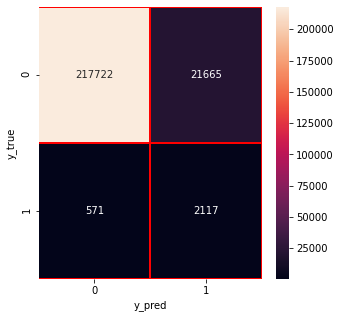

In [18]:
#Plot confusion matrix for test data

y_pred=y_pred_test
y_true=y_test

cm=confusion_matrix(y_true,y_pred)
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


**Observations**
*  There are lot of points which actually did not went into backorder but are classifed as product into backorder.
*  There are few points which actually went into backorder but are classifed as product which did not went into backorder.


##4. Visualize errors

###Classifying error datasets

In [19]:
#Storing true and predicted class labels in a dataframe
df_sc=pd.DataFrame()
df_sc['y_true']=y_test['went_on_backorder'].values
df_sc['y_pred']=y_pred_test
df_sc.reset_index()

#Index of misclassified points
idx_misclf=np.where(df_sc['y_true']!=df_sc['y_pred'])

#Index of correctly classified points
idx_corclf=np.where(df_sc['y_true']==df_sc['y_pred'])

#Storing importance indices
imp_idx = rf.feature_importances_.argsort()

#Storing important feature names
feature_names = list(x_test.columns.values)
imp_feature_indx = np.argsort(rf.feature_importances_)[::-1]
imp_value = np.take(rf.feature_importances_, imp_feature_indx[:10])
imp_feature_name = np.take(feature_names, imp_feature_indx[:10])
imp_cols_list=imp_feature_name.tolist()

#Misclassified dataset
x_test_misclf=x_test.iloc[idx_misclf][imp_cols_list]
x_test_misclf['y_pr_test']=y_pred_test[idx_misclf]
x_test_misclf['y_act_test']=y_test.values[idx_misclf]
y_test_misclf=y_pred_test[idx_misclf]

#Correctly classified dataset
x_test_corclf=x_test.iloc[idx_corclf][imp_cols_list]
x_test_corclf['y_pr_test']=y_pred_test[idx_corclf]
x_test_corclf['y_act_test']=y_test.values[idx_corclf]
y_test_corclf=y_pred_test[idx_corclf]

In [20]:
#Count of correctly predicted dataset
x_test_corclf['y_pr_test'].value_counts()

0.0    217722
1.0      2117
Name: y_pr_test, dtype: int64

* There are only few products which went into backorder which is true and that is observed in correctly classified dataset

In [21]:
#Count of misclassified dataset
x_test_misclf['y_pr_test'].value_counts()

1.0    21665
0.0      571
Name: y_pr_test, dtype: int64

* There are more products which actually did not went into backorder are classified as that went into backorder.
* There are few products which actually went into backorder but classified as that did not went into backorder
This need to analyse on these did not went into backorder

In [22]:
#Numerical statistics on correctly classified dataset
x_test_corclf.describe()

national_inv  ...     y_act_test
count  219839.000000  ...  219839.000000
mean        0.001795  ...       0.009630
std         1.037472  ...       0.097658
min        -0.111636  ...       0.000000
25%        -0.016583  ...       0.000000
50%        -0.016144  ...       0.000000
75%        -0.013544  ...       0.000000
max       410.103110  ...       1.000000

[8 rows x 12 columns]

* Majority of correctly classified points are centered around the mean although there are some outliers

In [23]:
#Numerical statistics on misclassified dataset
x_test_misclf.describe()

national_inv  ...    y_act_test
count  22236.000000  ...  22236.000000
mean      -0.016409  ...      0.025679
std        0.009384  ...      0.158180
min       -0.874892  ...      0.000000
25%       -0.016752  ...      0.000000
50%       -0.016651  ...      0.000000
75%       -0.016482  ...      0.000000
max        0.331110  ...      1.000000

[8 rows x 12 columns]

* Majority of misclassified points are centered around the mean although there are some outliers present

##5. Plot of predicted dataset

###5.1 PDF of correctly classified and incorrectly classified features

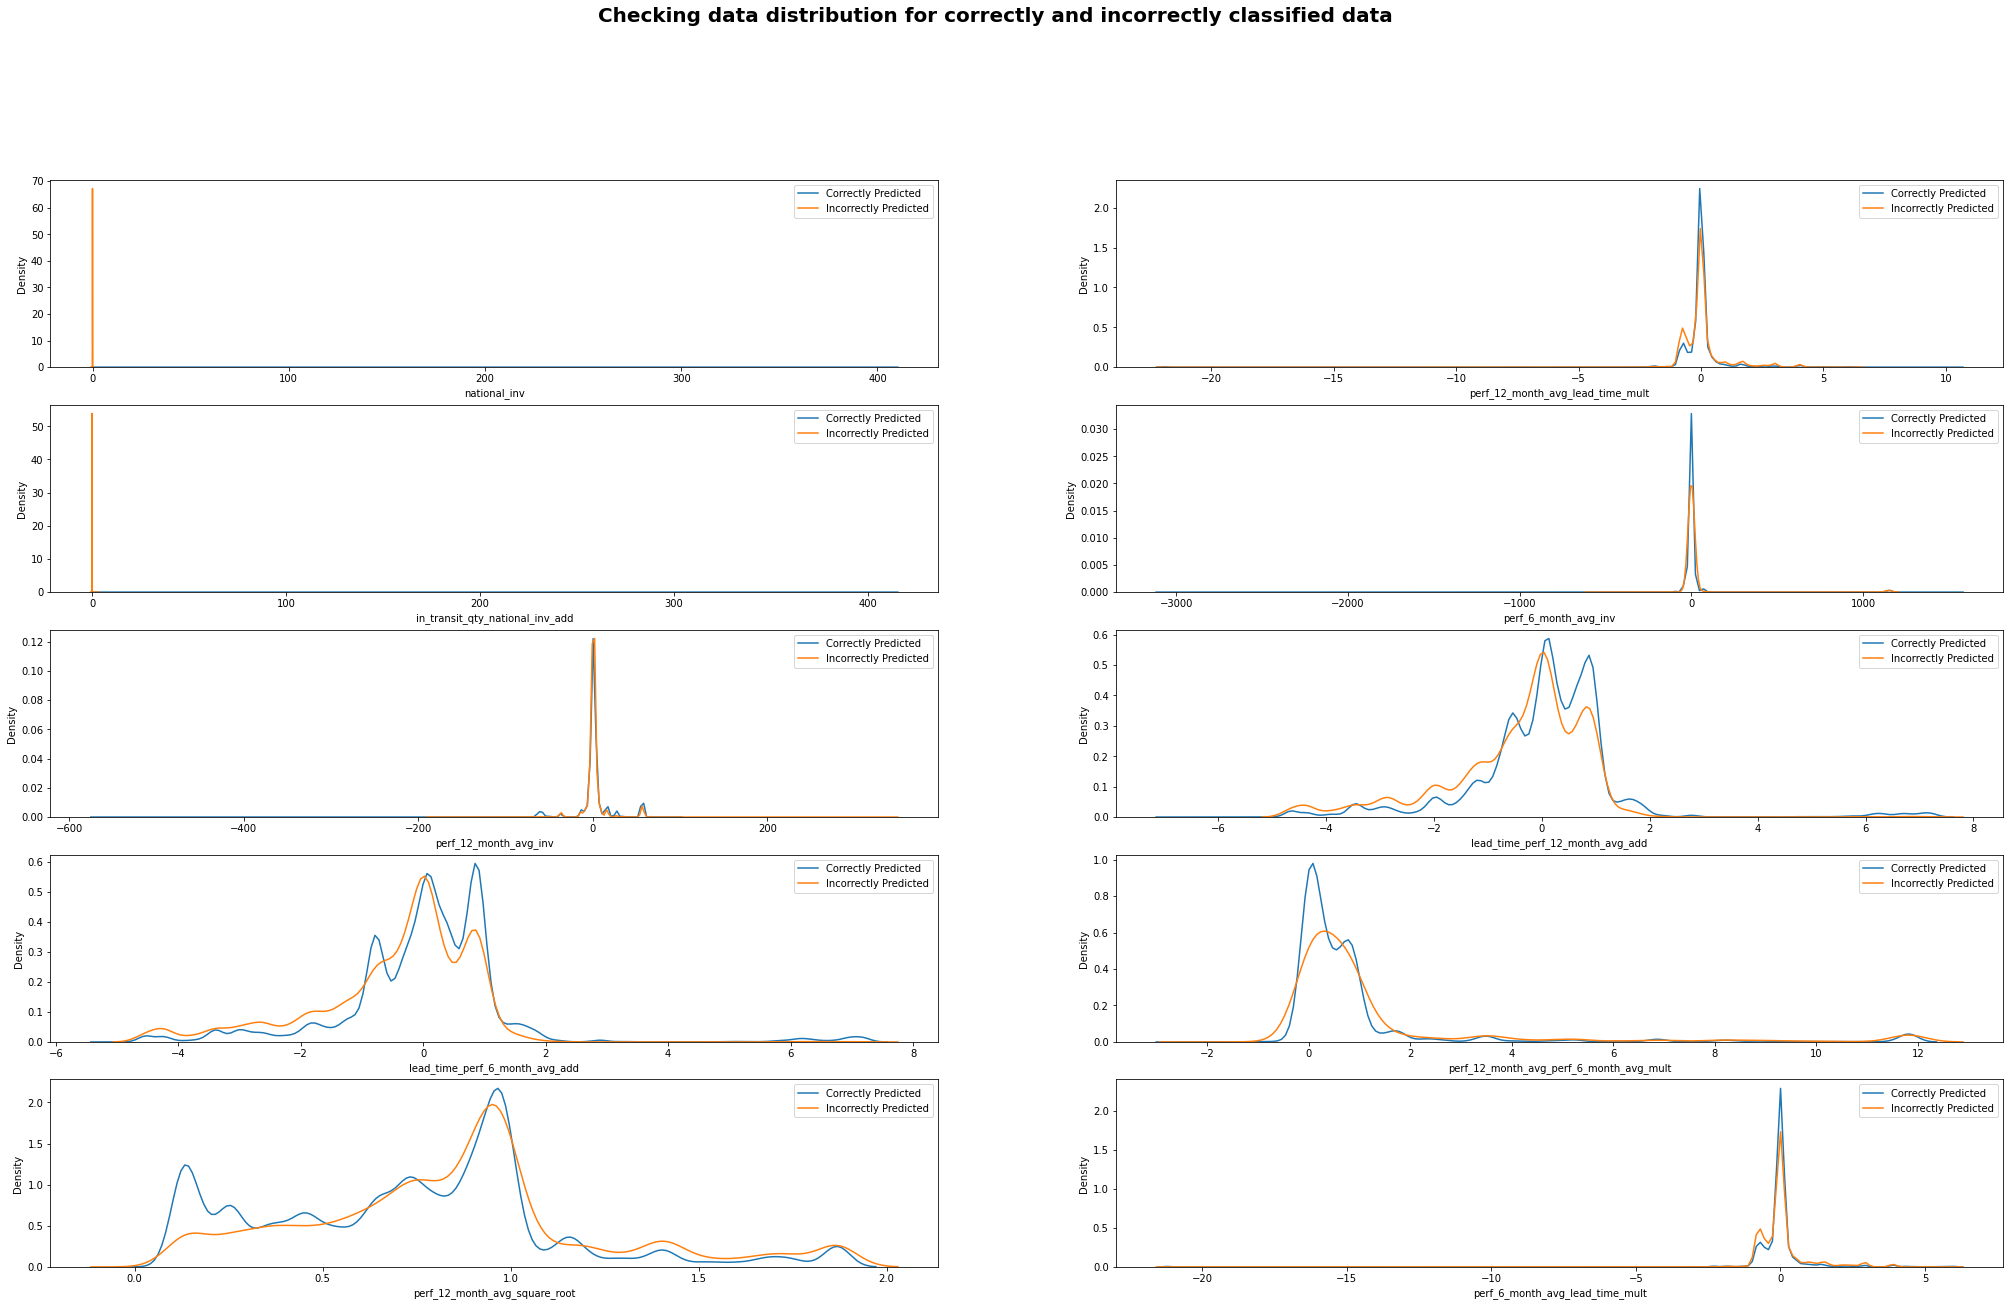

In [24]:
fig = plt.figure(figsize=(35,20))
fig.tight_layout(pad=3.0)
fig.suptitle('Checking data distribution for correctly and incorrectly classified data', fontsize=20, y=1,weight='bold')
#for idx, col in enumerate(['forecast_3_month_local_bo_qty_add','local_bo_qty_forecast_6_month_add','in_transit_qty_forecast_6_month_mult','national_inv','local_bo_qty_forecast_3_month_add','forecast_3_month','national_inv_in_transit_qty_add','forecast_3_month_in_transit_qty_mult','national_inv_square_root','national_inv_log']):
for idx, col in enumerate(imp_cols_list):
 ax=fig.add_subplot(5, 2, idx+1)
 sns.distplot(x_test_corclf[col], hist=False)
 sns.distplot(x_test_misclf[col], hist=False)
 ax.legend(["Correctly Predicted", "Incorrectly Predicted"])

* Both the correctly classified and misclassified dataset follows the same distribution and they are highly overlapping
* Some extreme points were predicted correctly by the best fit model whereas some were not so removing some of these points do not seem to affect much on perfomance.

### 5.2 Box Plot

#### 5.2.1 Box Plot of correctly classified dataset

In [29]:
#Assigning correctly classified dataset
df=x_test_corclf

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

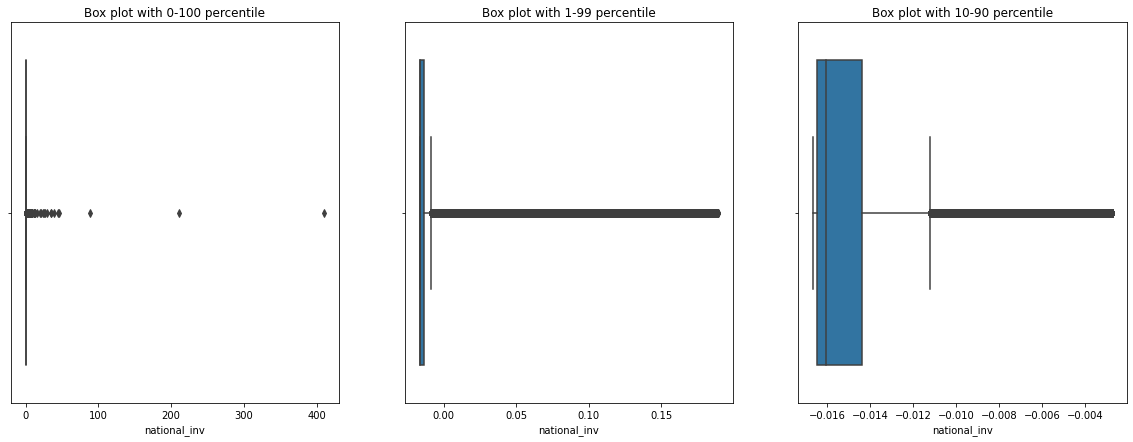

In [30]:
#Box Plot of national_inv
feature='national_inv'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

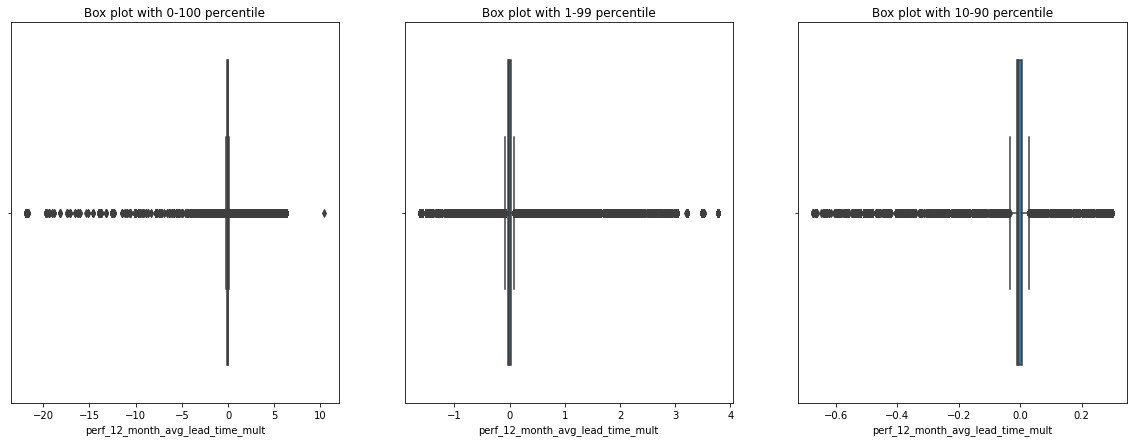

In [31]:
#Box Plot of perf_12_month_avg_lead_time_mult
feature='perf_12_month_avg_lead_time_mult'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the left as well as right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

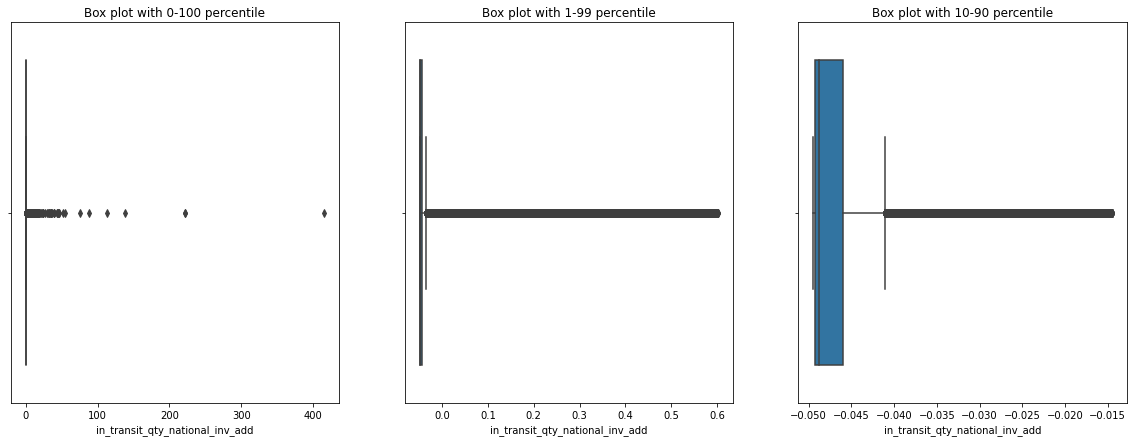

In [32]:
#Box Plot of in_transit_qty_national_inv_add
feature='in_transit_qty_national_inv_add'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are lot of extreme points on the right side of the distribution.

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

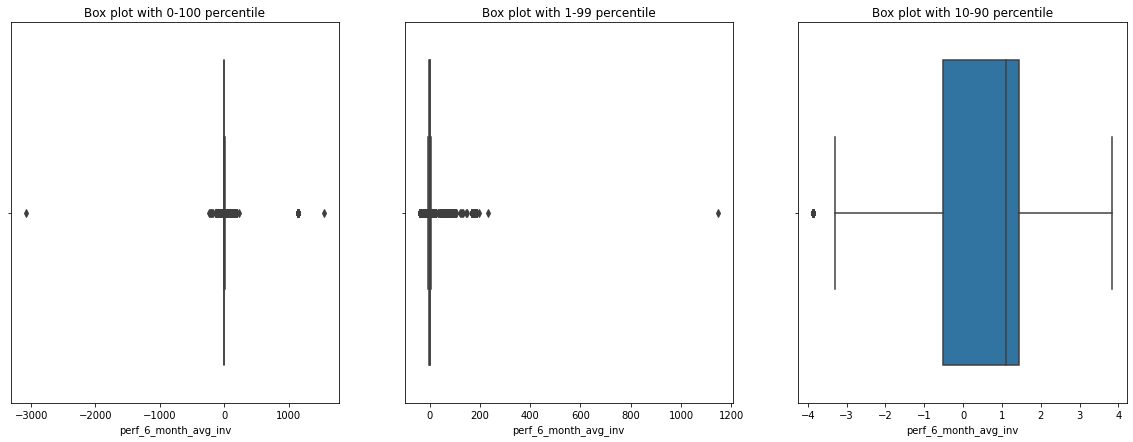

In [33]:
#Box Plot of perf_6_month_avg_inv

feature='perf_6_month_avg_inv'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are very few extreme points for this distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

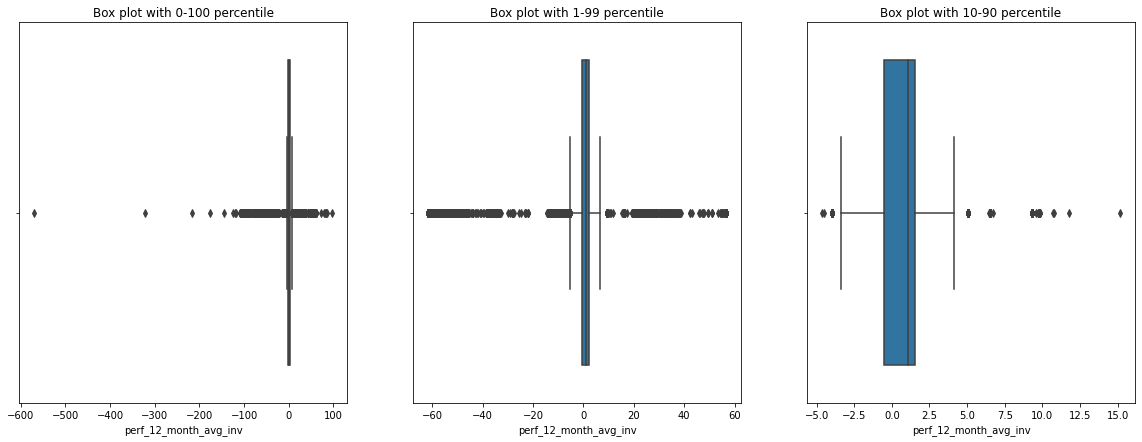

In [34]:
#Box Plot of perf_12_month_avg_inv

feature='perf_12_month_avg_inv'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the left and right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

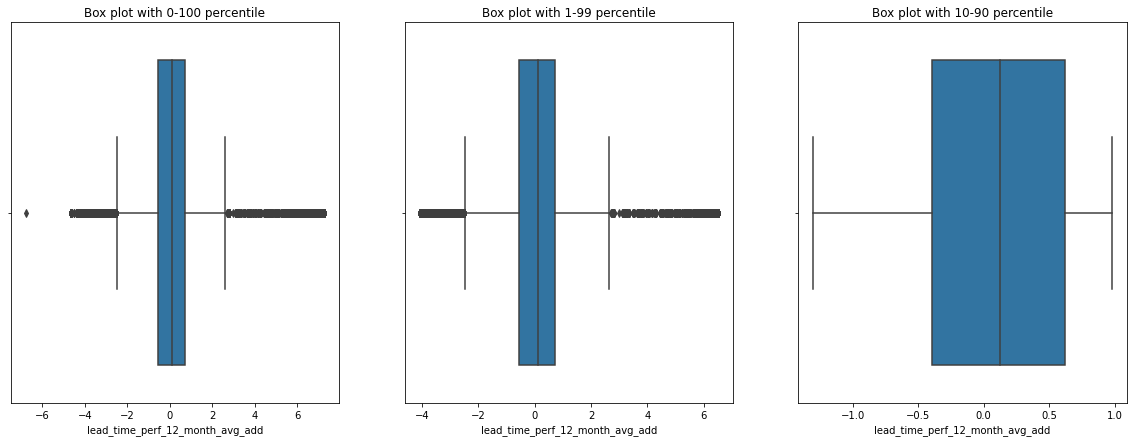

In [35]:
#Box Plot of lead_time_perf_12_month_avg_add

feature='lead_time_perf_12_month_avg_add'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the left and right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

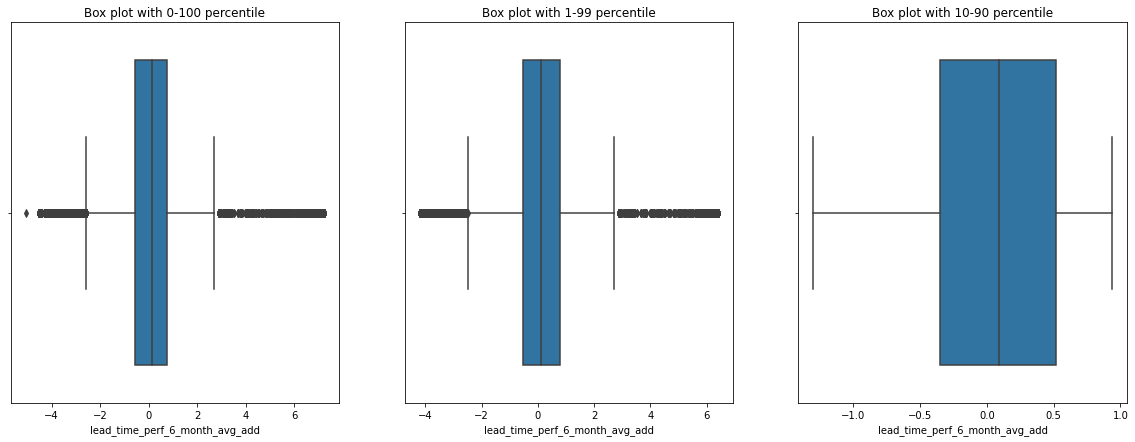

In [36]:
#Box Plot of lead_time_perf_6_month_avg_add

feature='lead_time_perf_6_month_avg_add'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the left and right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

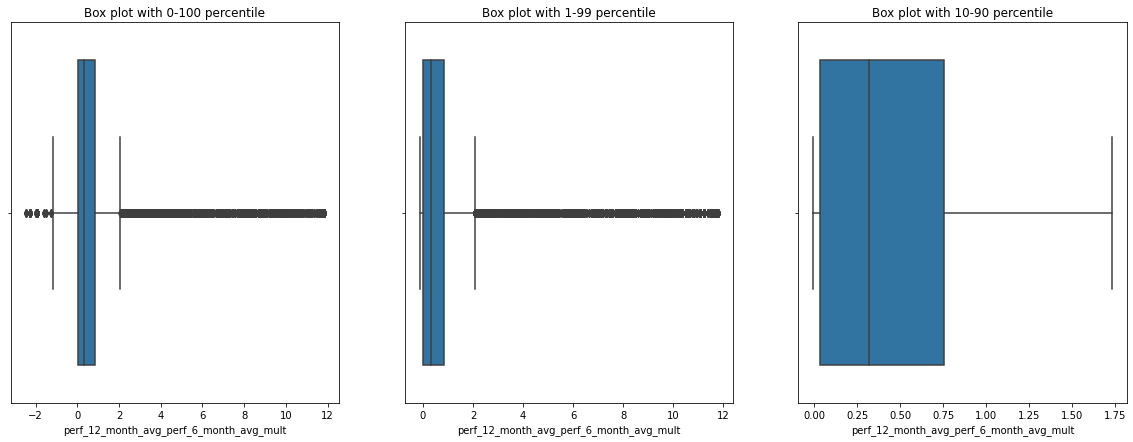

In [37]:
#Box Plot of perf_12_month_avg_perf_6_month_avg_mult

feature='perf_12_month_avg_perf_6_month_avg_mult'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are lot of extreme points on the right side of the distribution.
* The distribution of the feature is rightly skewed

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

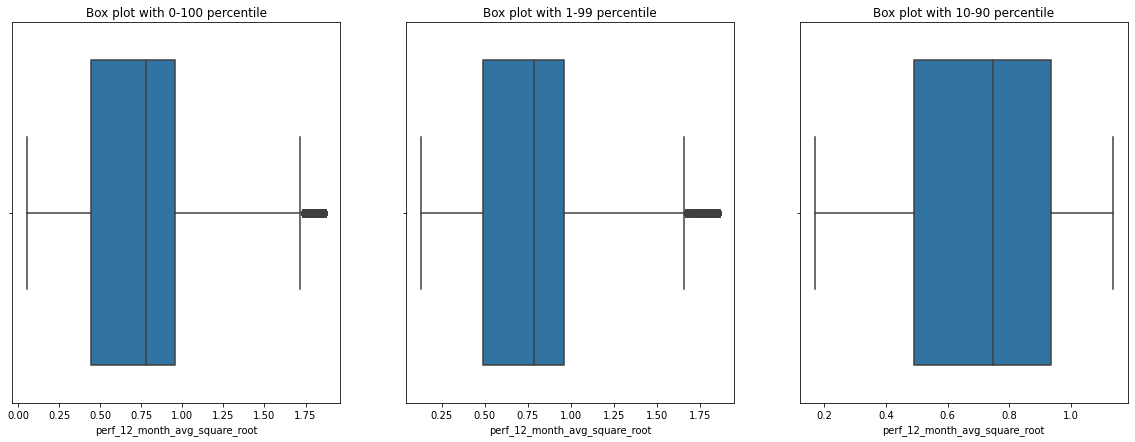

In [38]:
#Box Plot of perf_12_month_avg_square_root

feature='perf_12_month_avg_square_root'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are few extreme points on the right side of the distribution.


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

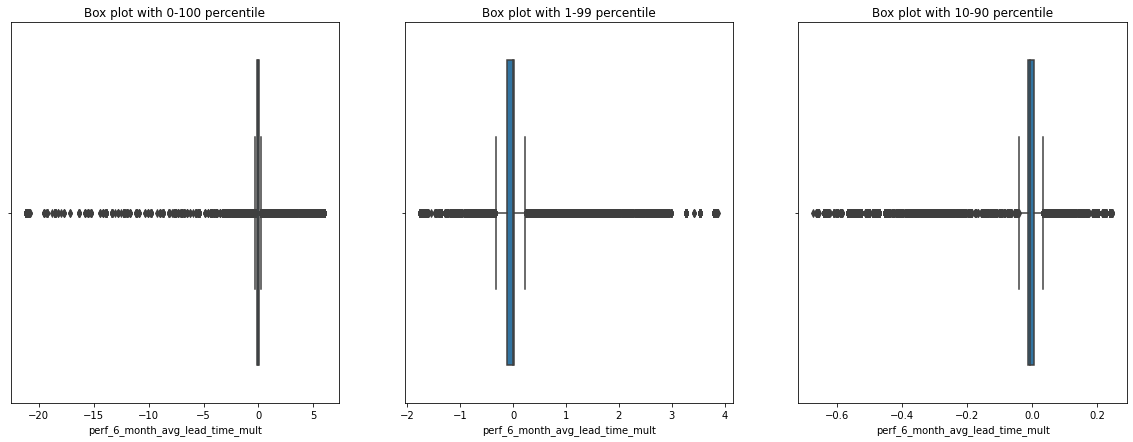

In [39]:
#Box Plot of perf_6_month_avg_lead_time_mult

feature='perf_6_month_avg_lead_time_mult'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are lot of extreme points on the left and right side of the distribution.

#### 5.2.2 Box Plot of misclassified dataset

In [40]:
#Assigning misclassified dataset
df=x_test_misclf

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

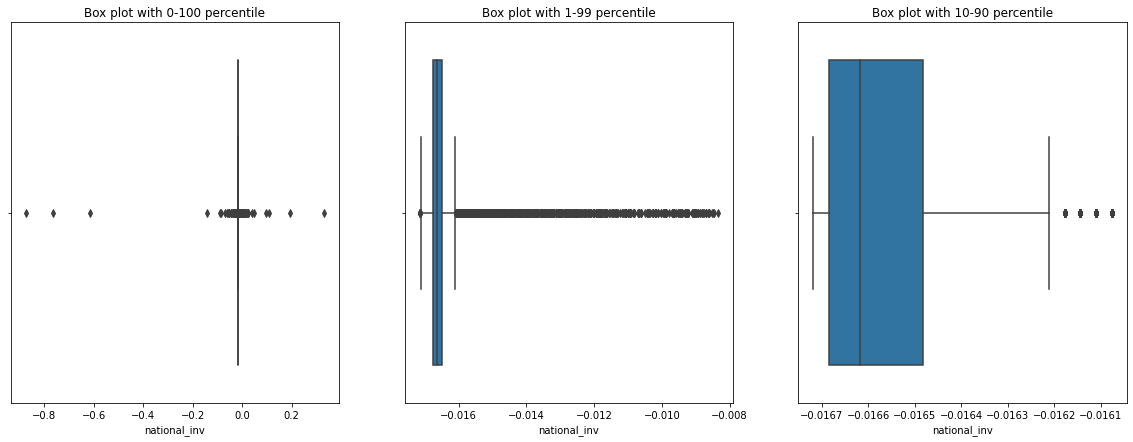

In [41]:
#Box Plot of national_inv

feature='national_inv'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are lot of extreme points on the right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

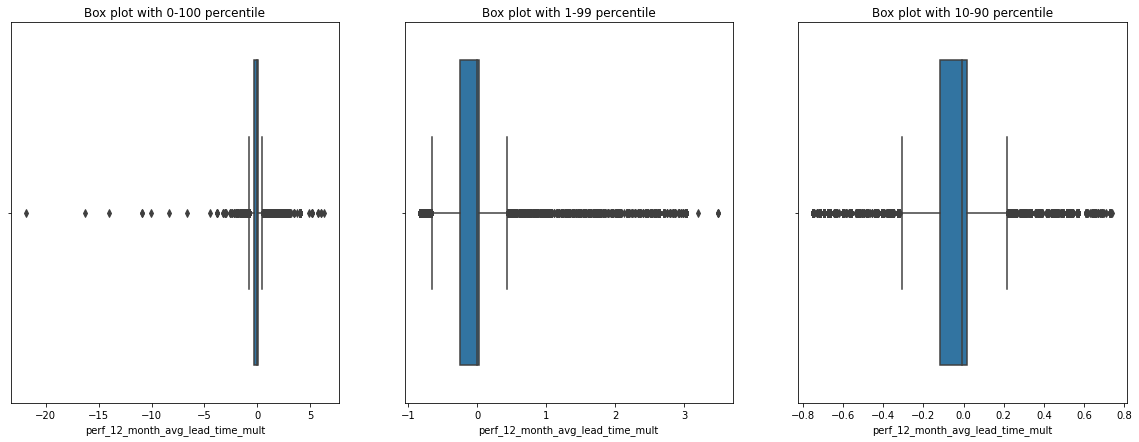

In [42]:
#Box Plot of perf_12_month_avg_lead_time_mult

feature='perf_12_month_avg_lead_time_mult'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the left and right side of the distribution


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

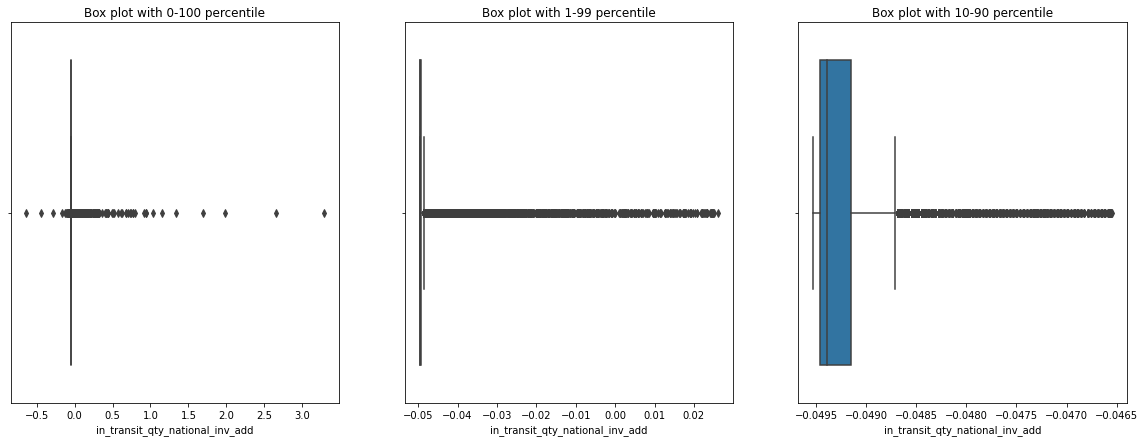

In [43]:
#Box Plot of in_transit_qty_national_inv_add

feature='in_transit_qty_national_inv_add'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are lot of extreme points on the right side 


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

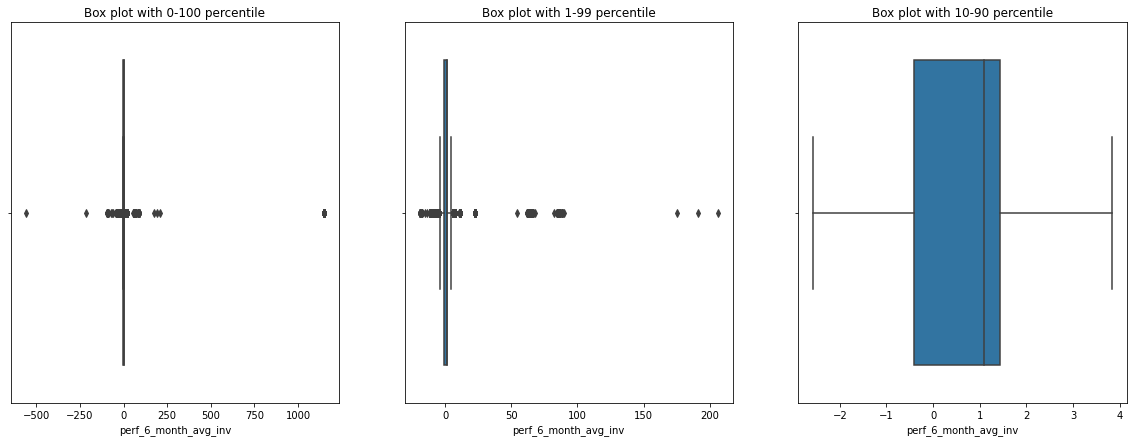

In [44]:
#Box Plot of perf_6_month_avg_inv

feature='perf_6_month_avg_inv'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are few  extreme points on the left and right side of the distribution


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

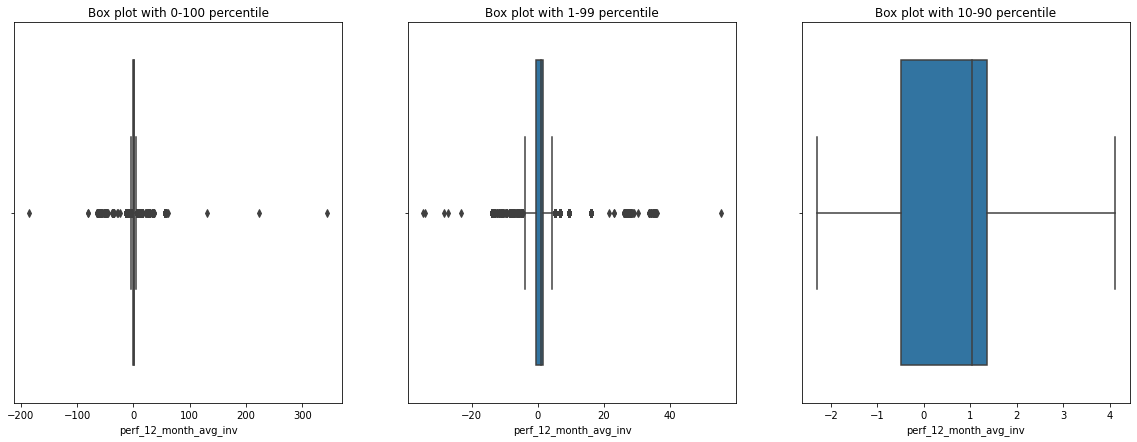

In [45]:
#Box Plot of perf_12_month_avg_inv

feature='perf_12_month_avg_inv'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are few extreme points on the left and right side of the distribution


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

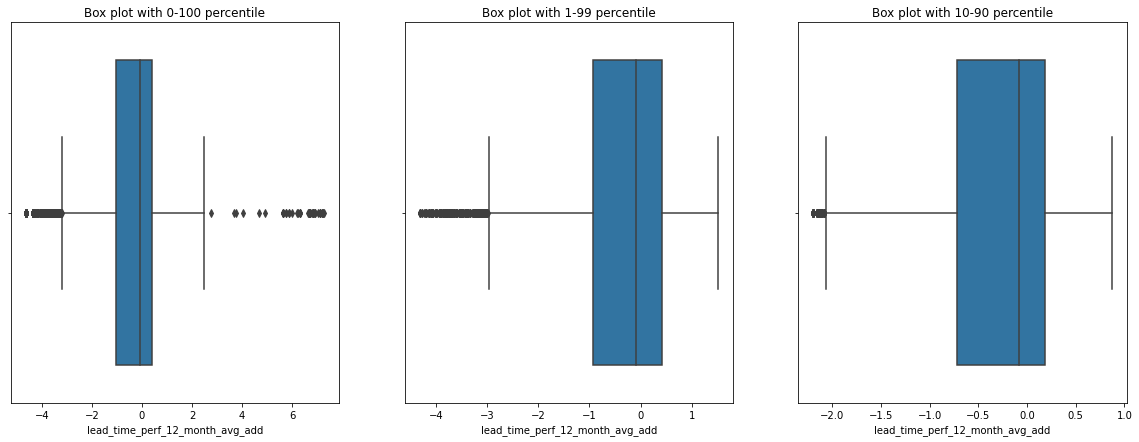

In [46]:
#Box Plot of lead_time_perf_12_month_avg_add

feature='lead_time_perf_12_month_avg_add'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are few extreme points on the left and right side of the distribution


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

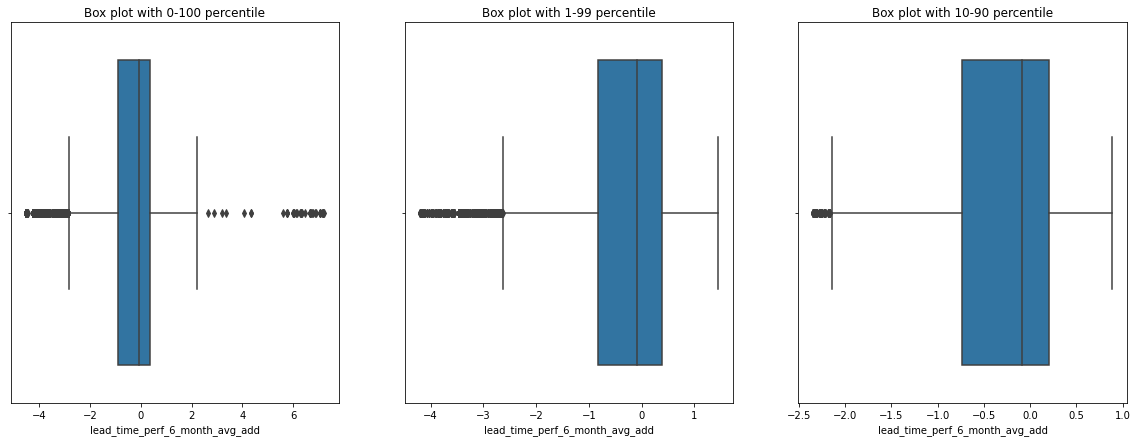

In [47]:
#Box Plot of lead_time_perf_6_month_avg_add

feature='lead_time_perf_6_month_avg_add'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are lot of extreme points on the right side of the distribution
* There are few points on the left side


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

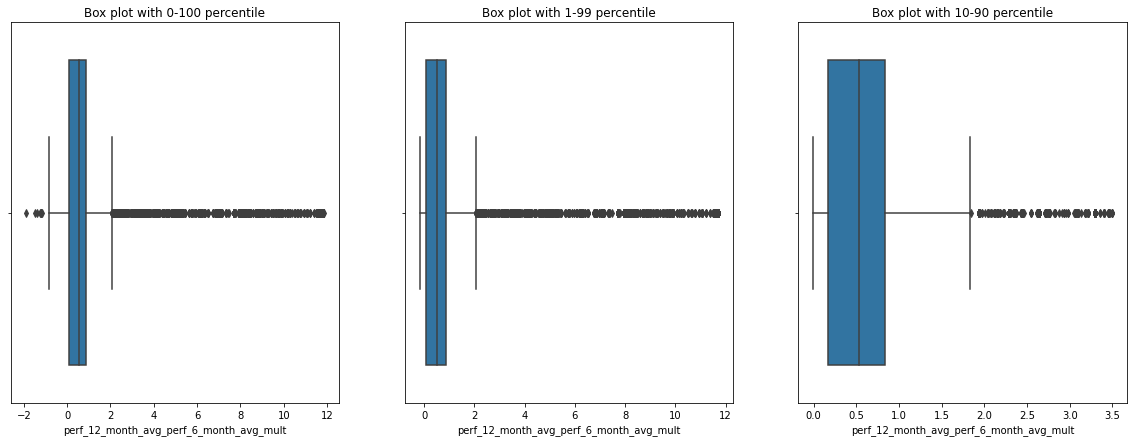

In [48]:
#Box Plot of perf_12_month_avg_perf_6_month_avg_mult

feature='perf_12_month_avg_perf_6_month_avg_mult'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are extreme points on the right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

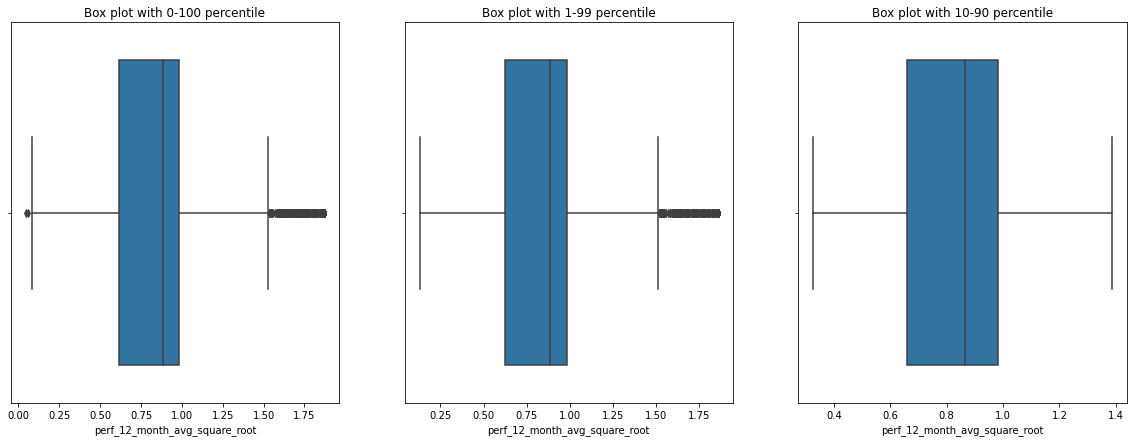

In [49]:
#Box Plot of perf_12_month_avg_square_root

feature='perf_12_month_avg_square_root'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the right side of the distribution

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

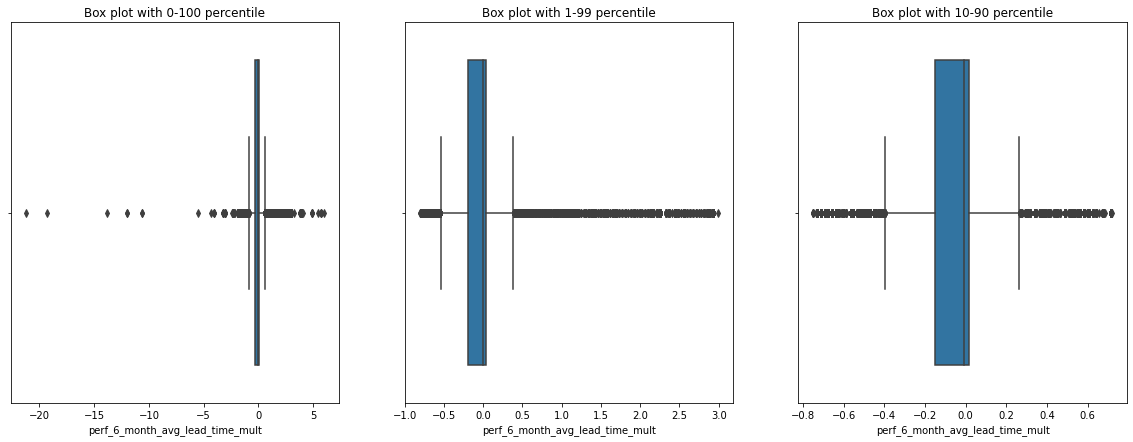

In [50]:
#Box Plot of perf_6_month_avg_lead_time_mult

feature='perf_6_month_avg_lead_time_mult'
df1= per_dataframe(df,feature,0.01,0.99)
df2= per_dataframe(df,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

* There are some extreme points on the right side of the distribution
* There are few points on the left side of the distributon


### 5.3 Scatter Plot

In [51]:
#Random Sample of points for correctly classified points
undersample = RandomUnderSampler()
x_test_corclf_under, y_test_corclf_under = undersample.fit_resample(x_test_corclf, y_test_corclf)
x_test_corclf_under=pd.DataFrame(x_test_corclf_under,columns=x_test_corclf.columns)

In [52]:
#Random Sample of points for misclassified points
undersample = RandomUnderSampler()
x_test_misclf_under, y_test_misclf_under = undersample.fit_resample(x_test_misclf, y_test_misclf)
x_test_misclf_under=pd.DataFrame(x_test_misclf_under,columns=x_test_misclf.columns)

#### 5.3.1 Scatter Plot for actual and predicted points for correctly classified dataset

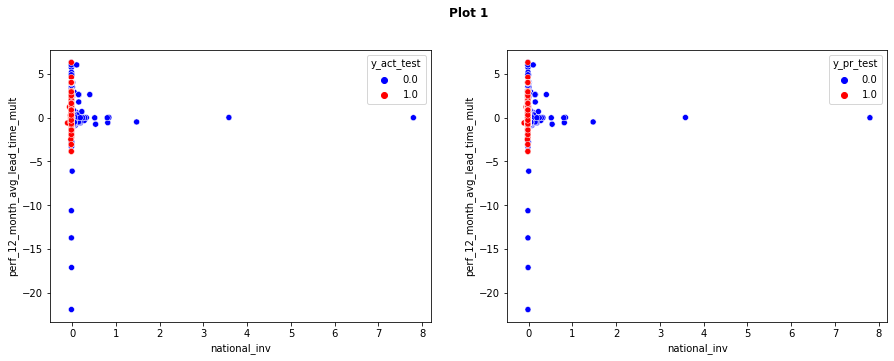

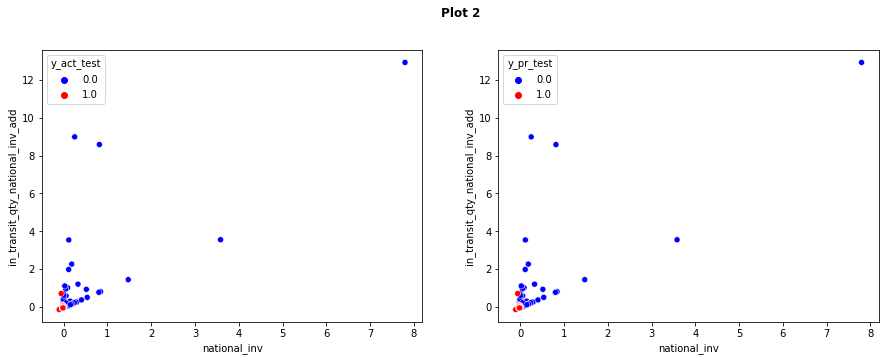

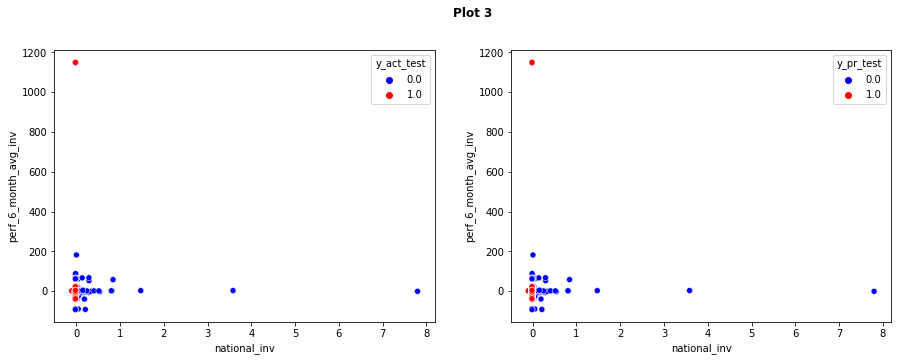

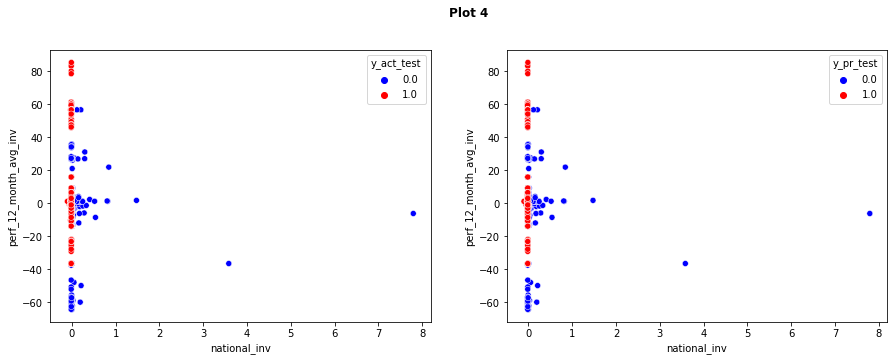

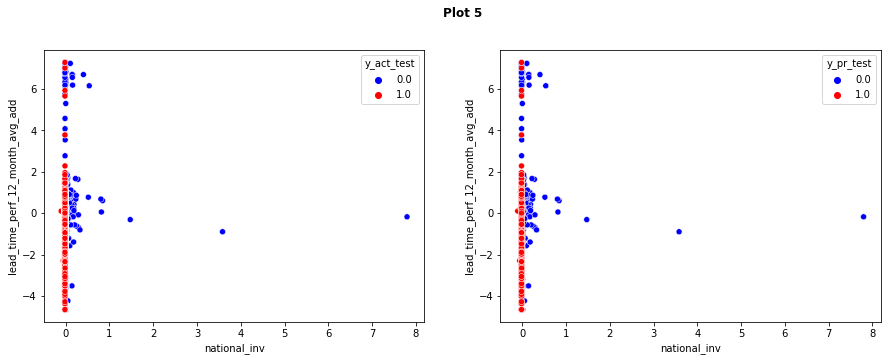

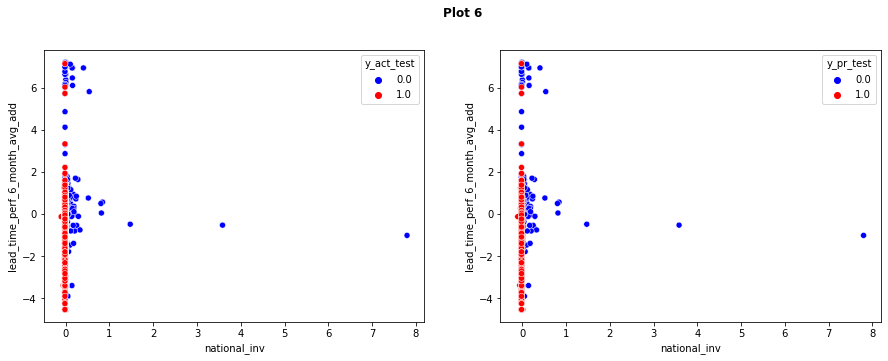

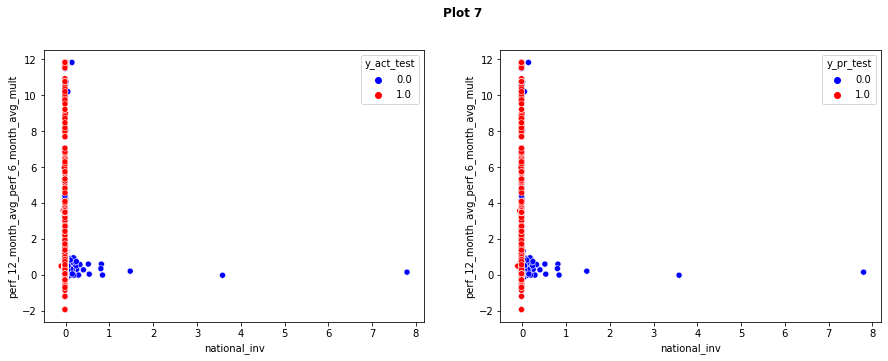

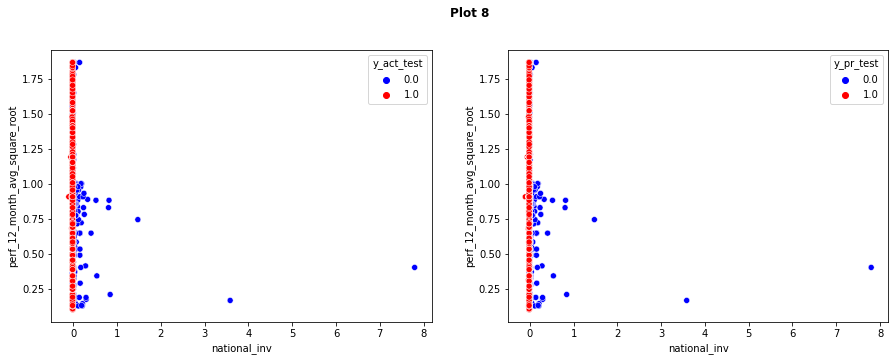

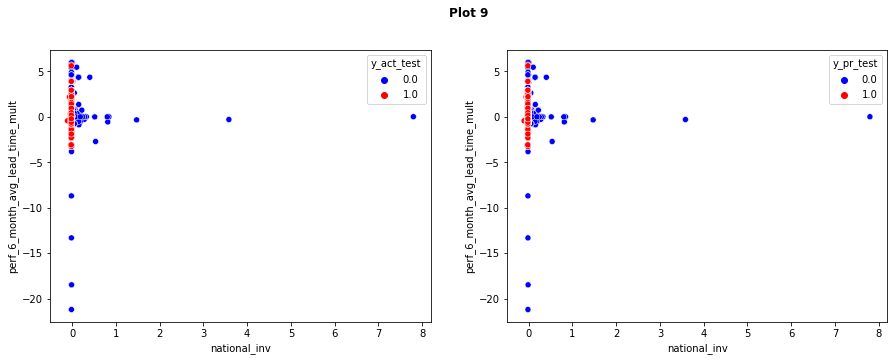

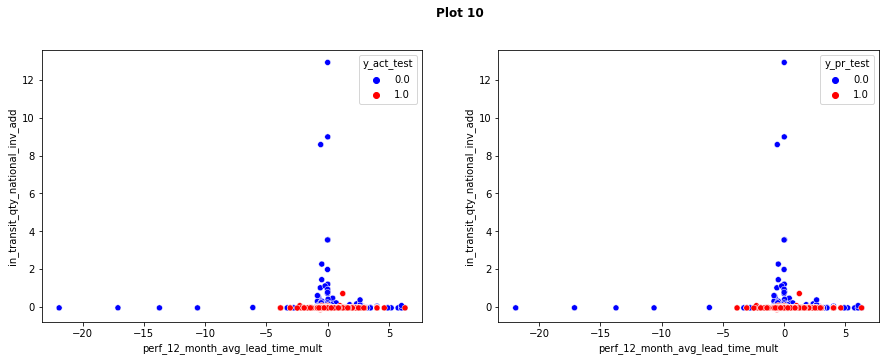

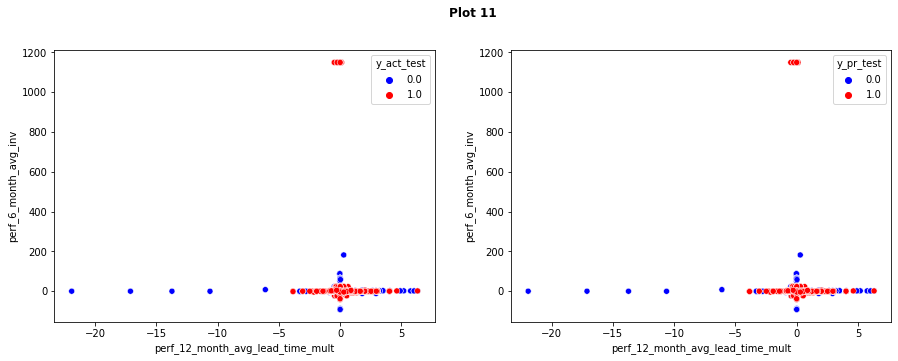

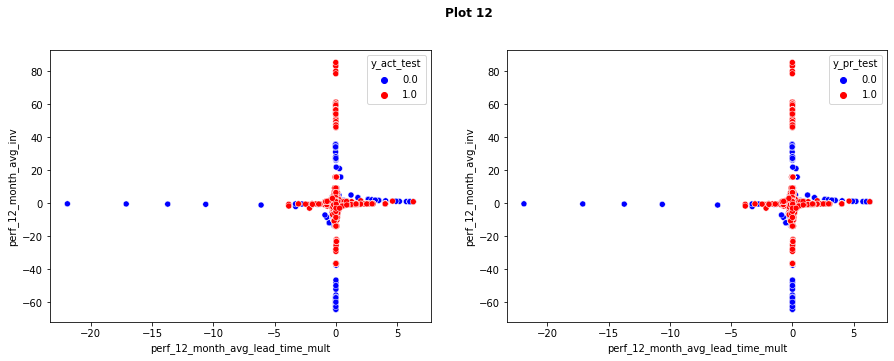

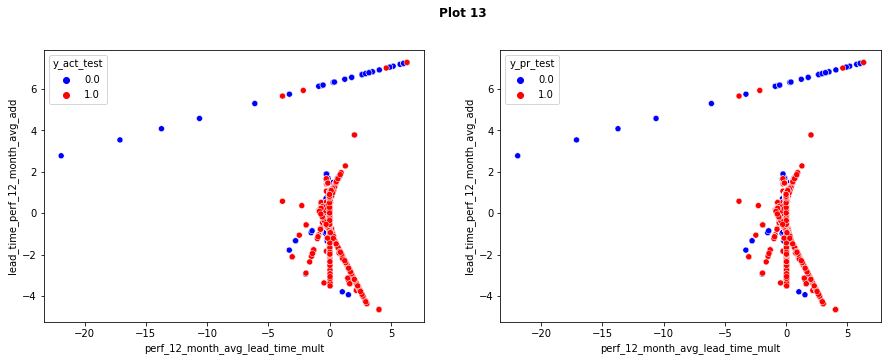

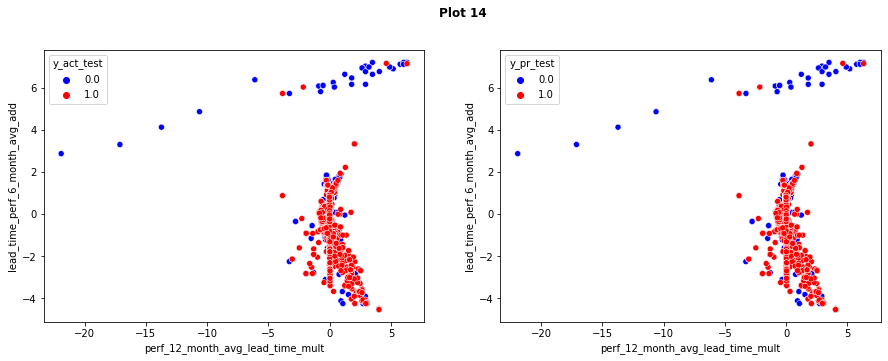

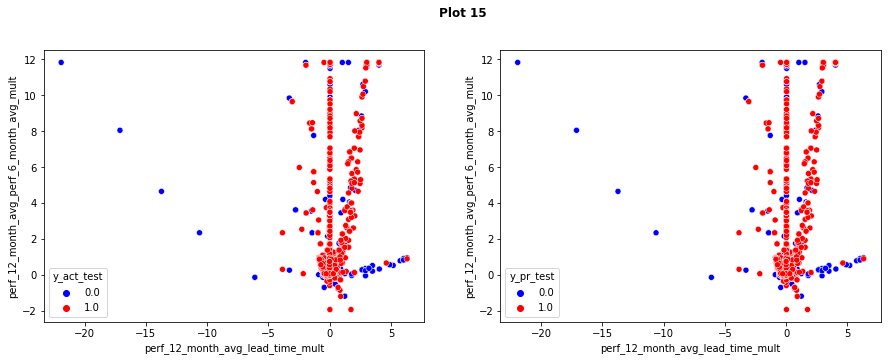

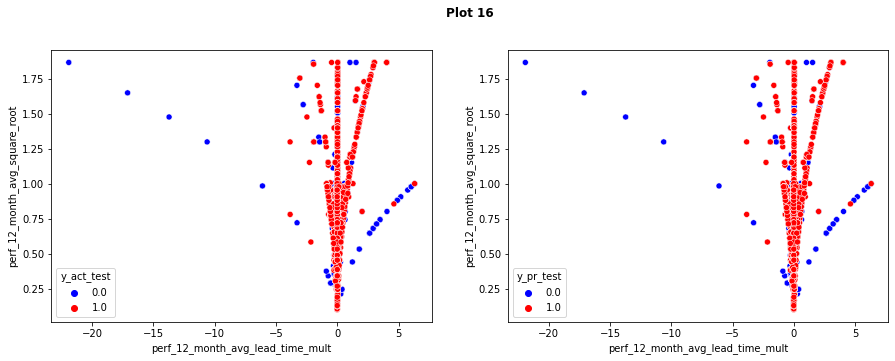

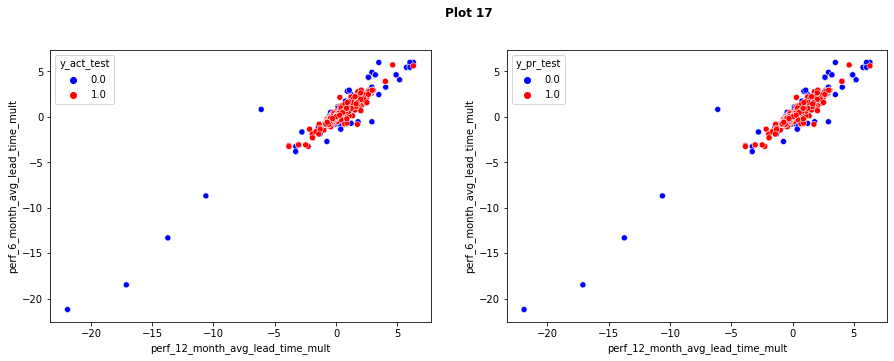

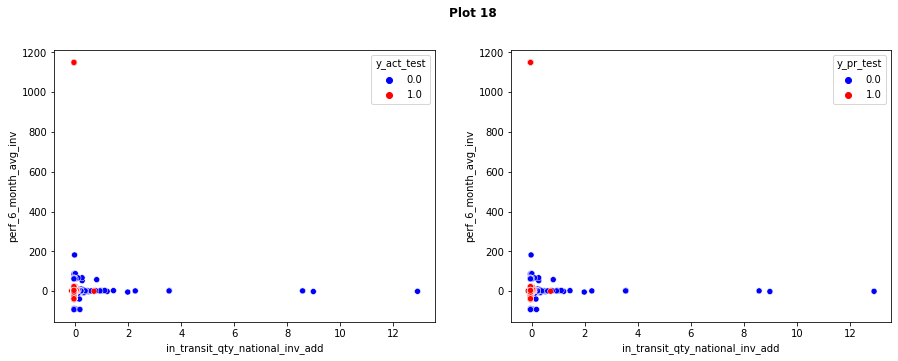

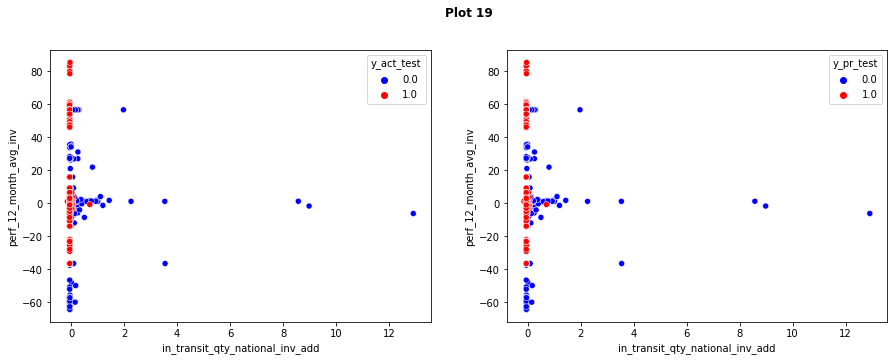

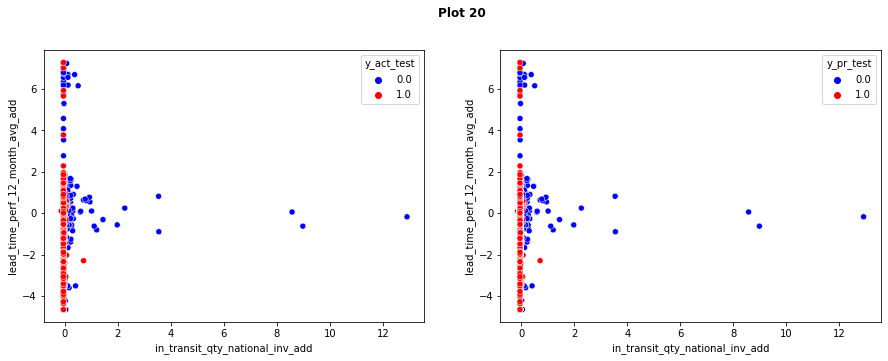

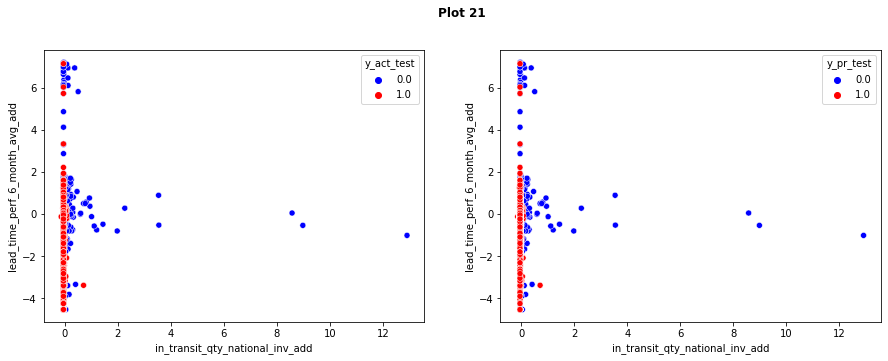

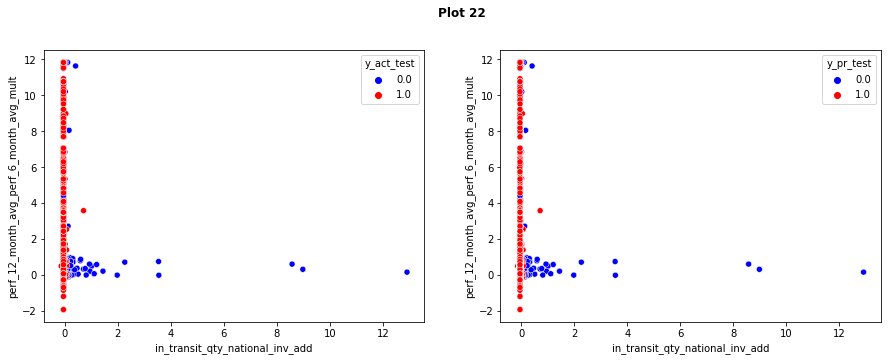

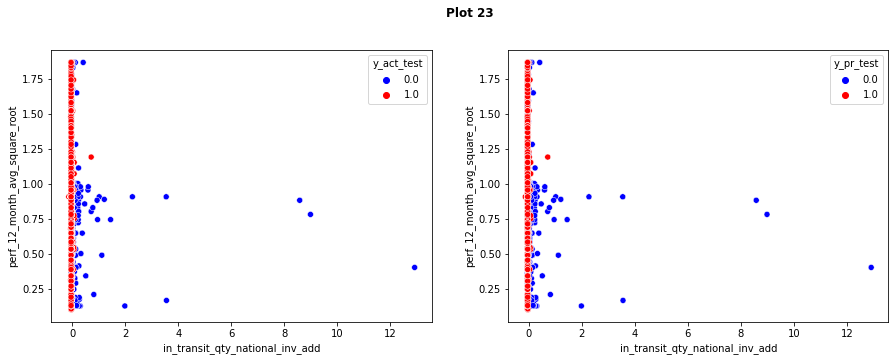

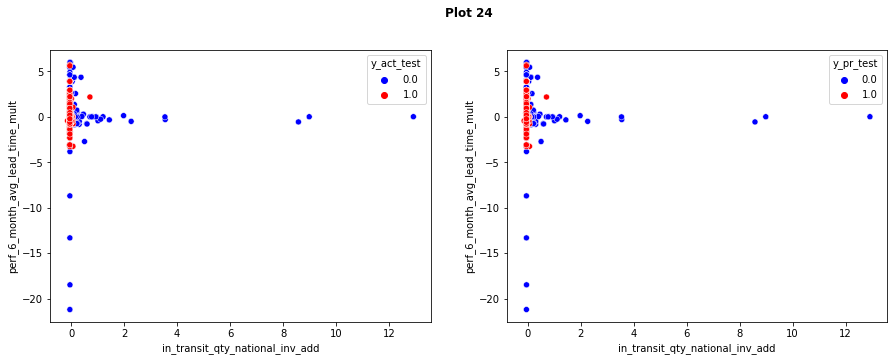

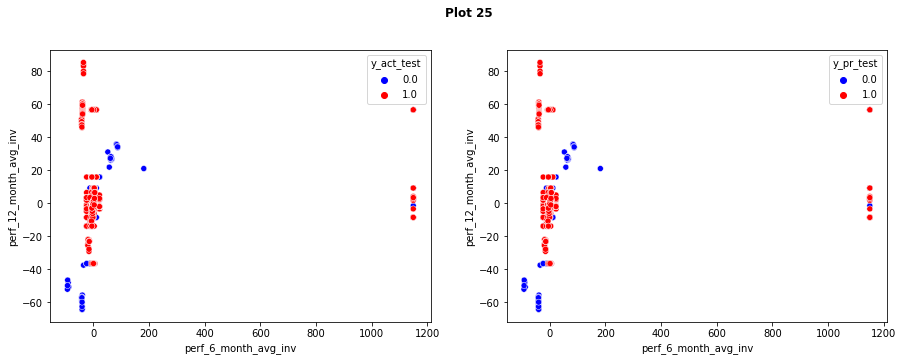

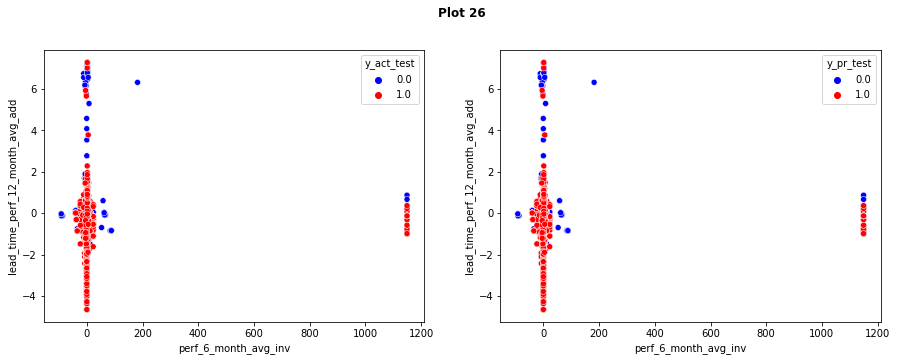

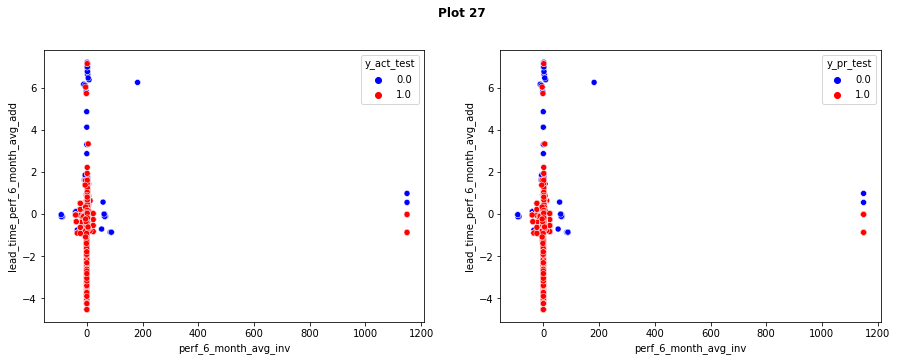

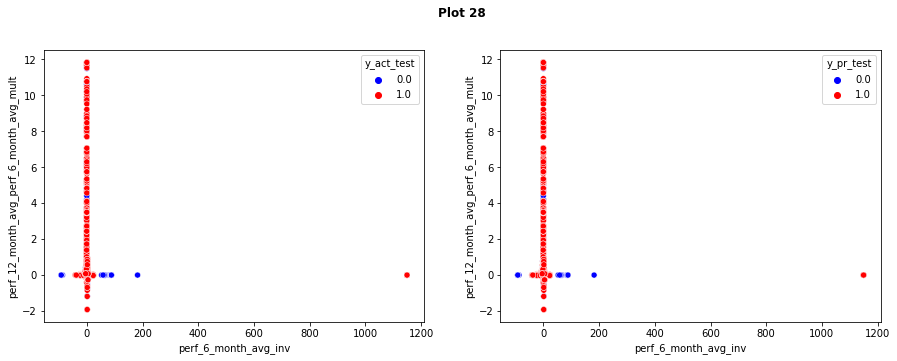

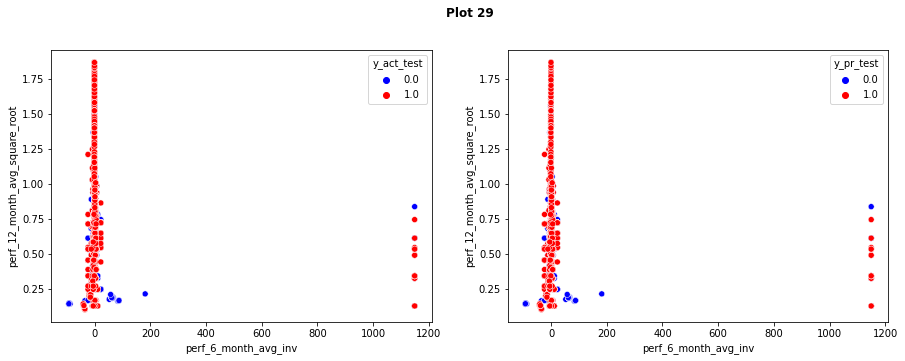

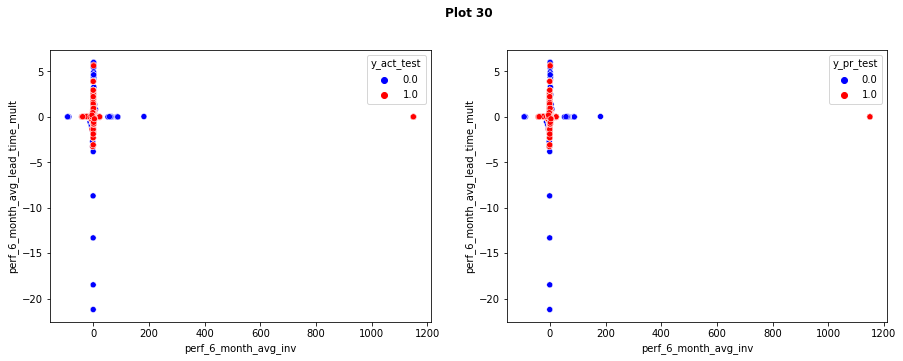

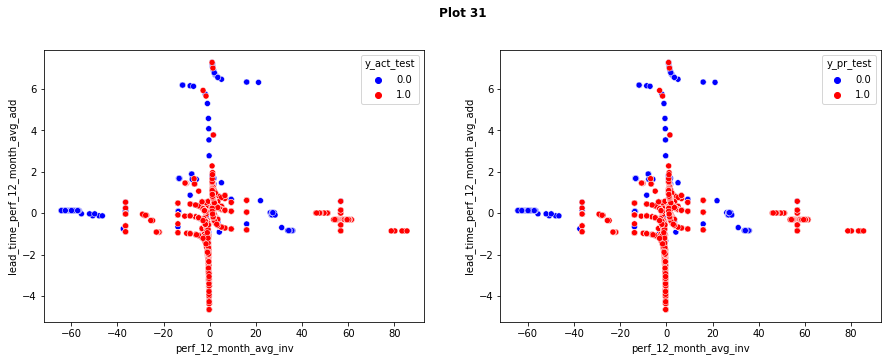

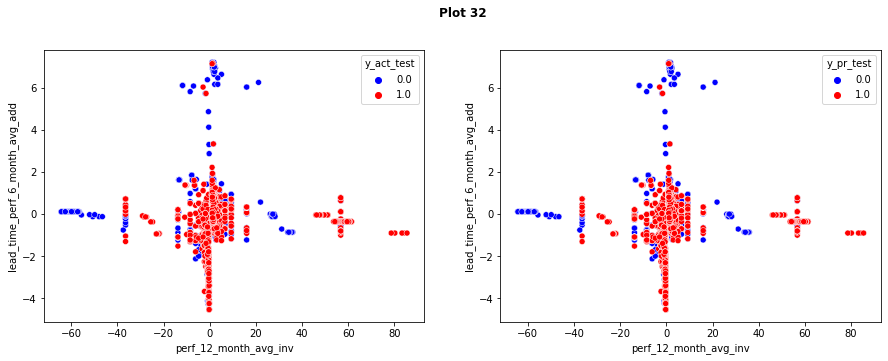

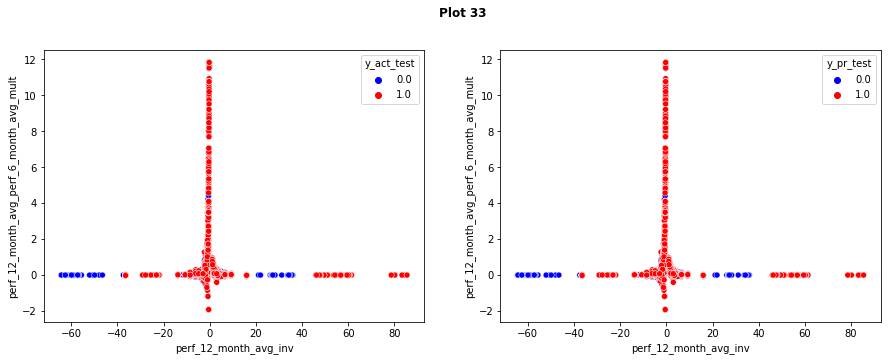

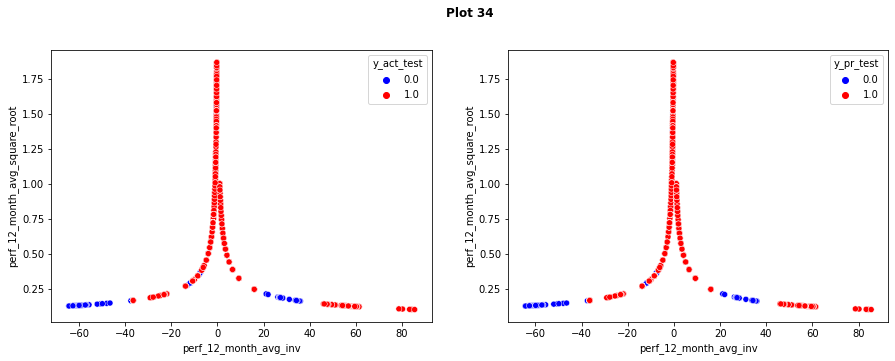

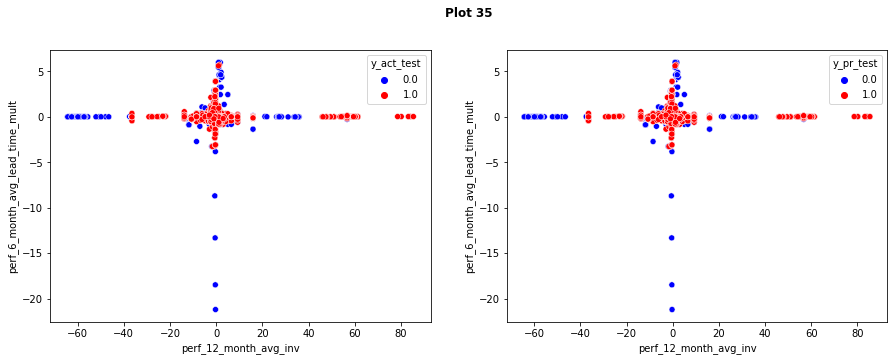

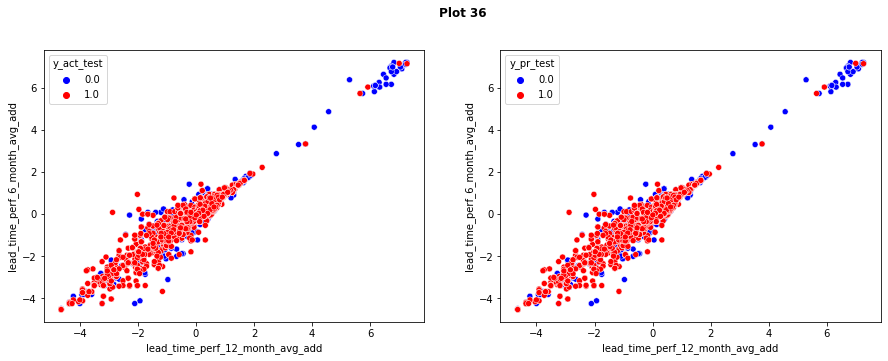

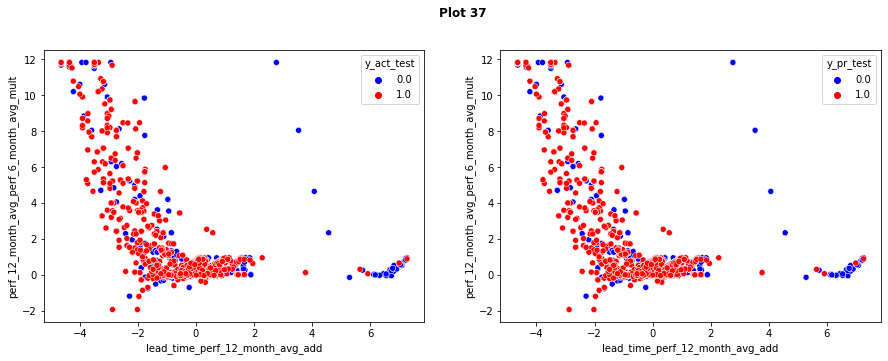

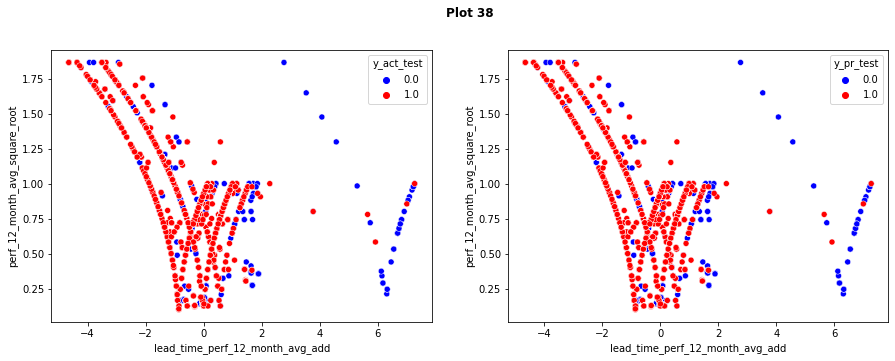

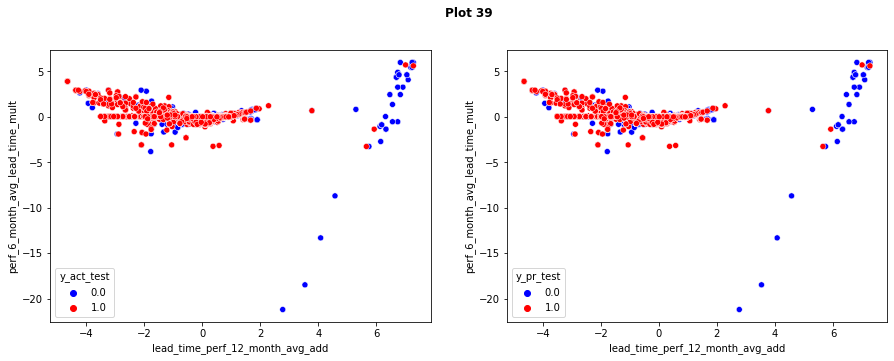

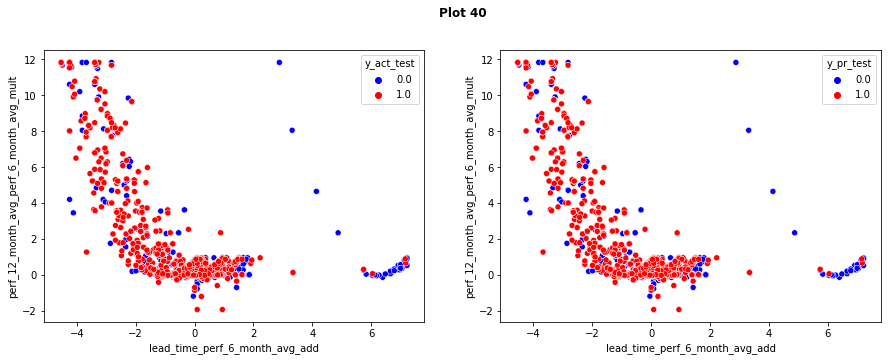

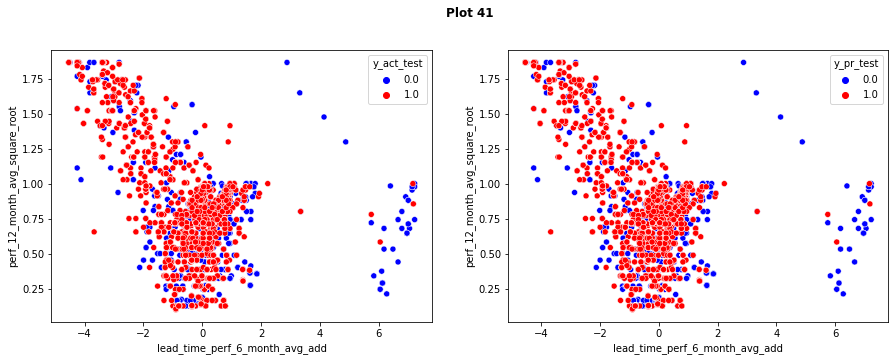

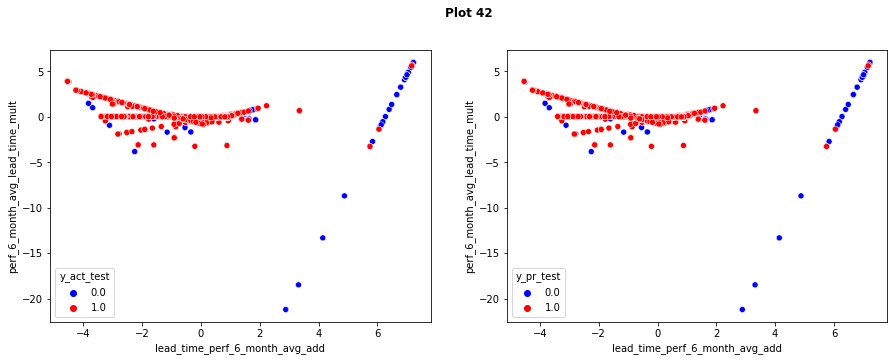

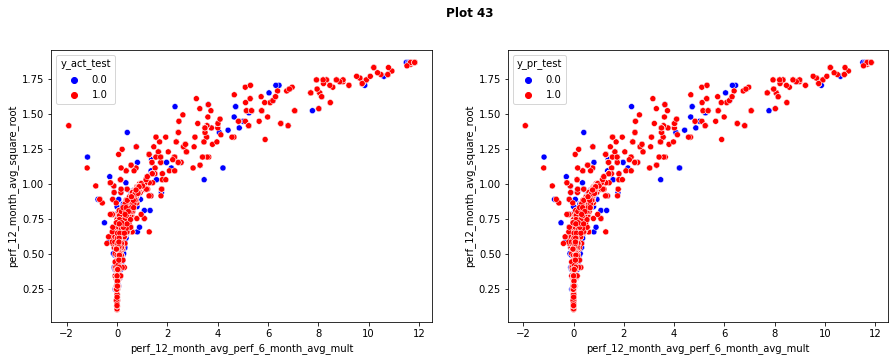

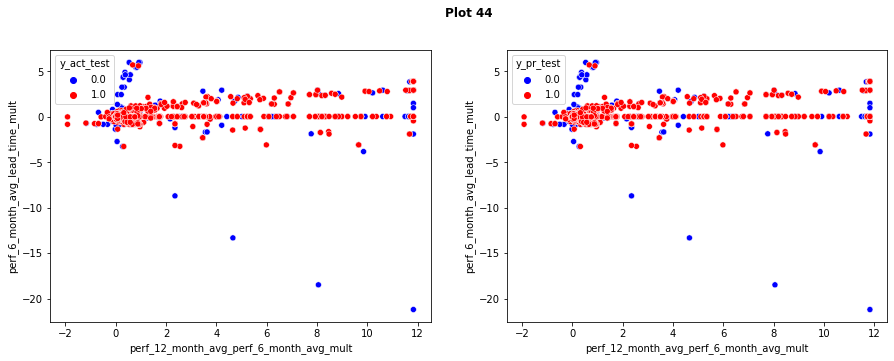

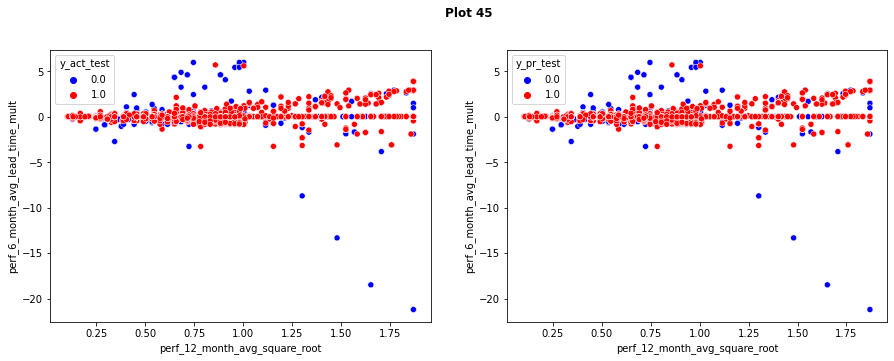

In [53]:
for idx, val in enumerate(itertools.combinations(imp_cols_list,2)):
 
 fig,ax=plt.subplots(1, 2, figsize=(15,5))
 sns.scatterplot(x=val[0], y=val[1], data=x_test_corclf_under,ax=ax[0], hue='y_act_test',palette=['blue','red'])
 sns.scatterplot(x=val[0], y=val[1], data=x_test_corclf_under, ax=ax[1],hue='y_pr_test',palette=['blue','red'])
 ax[0].set_title("Plot " + str(idx+1), x=1.1,y=1.1 ,fontweight ="bold")
 

#### 5.3.2 Scatter Plot for actual and predicted points for misclassified dataset

<Figure size 3240x3240 with 0 Axes>

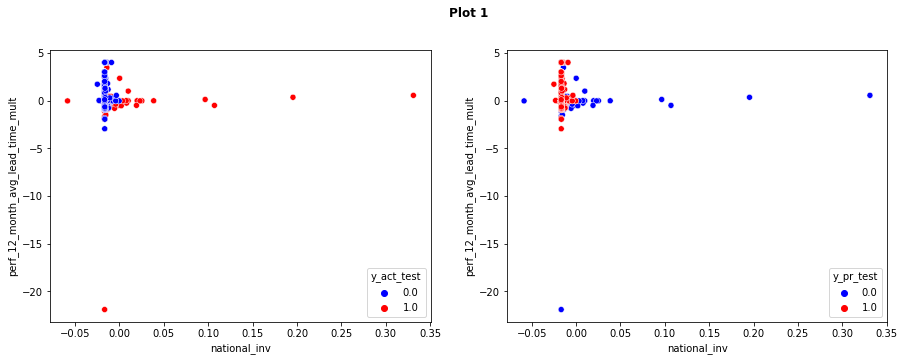

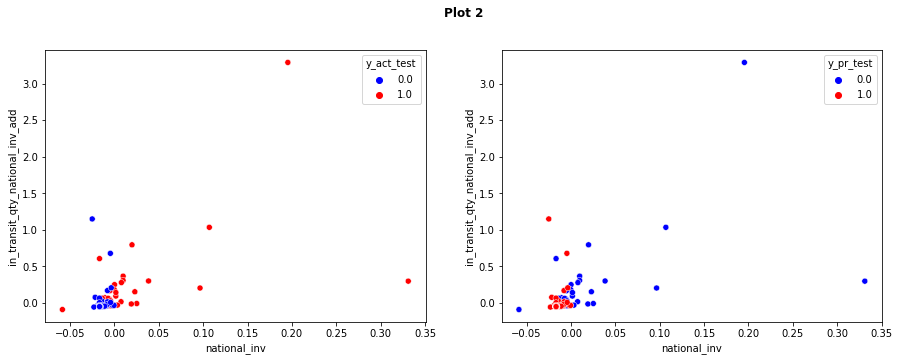

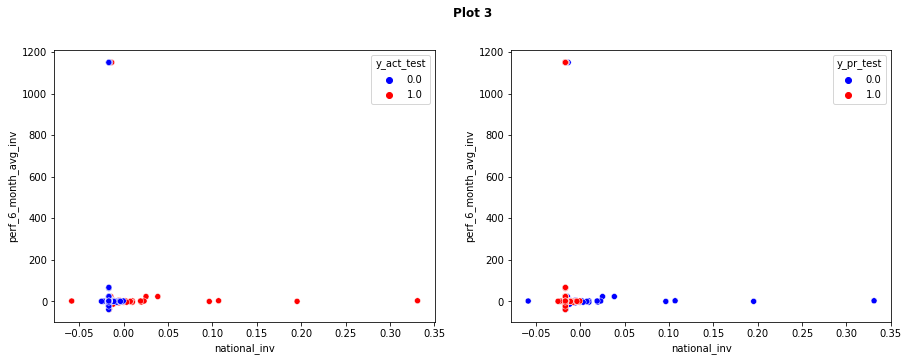

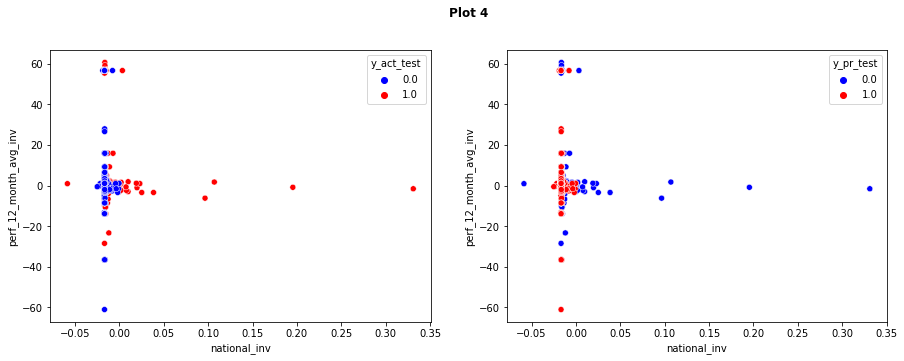

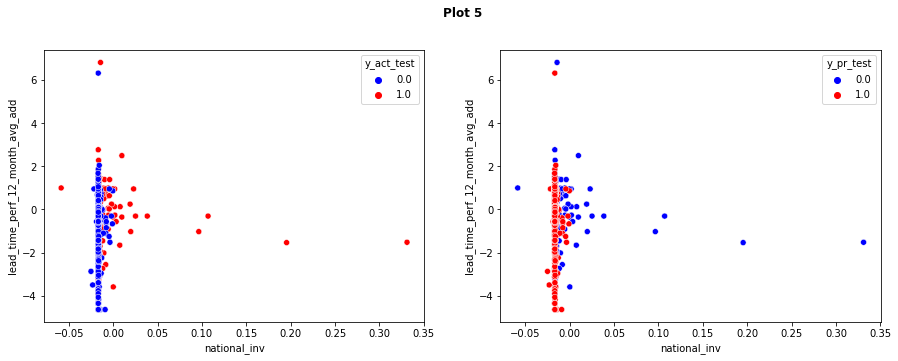

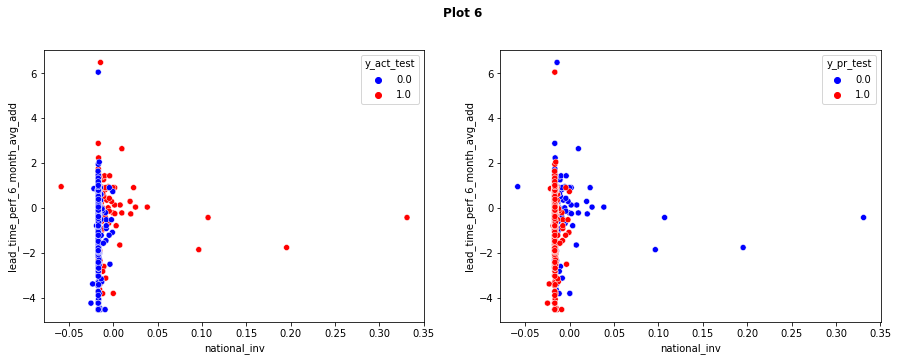

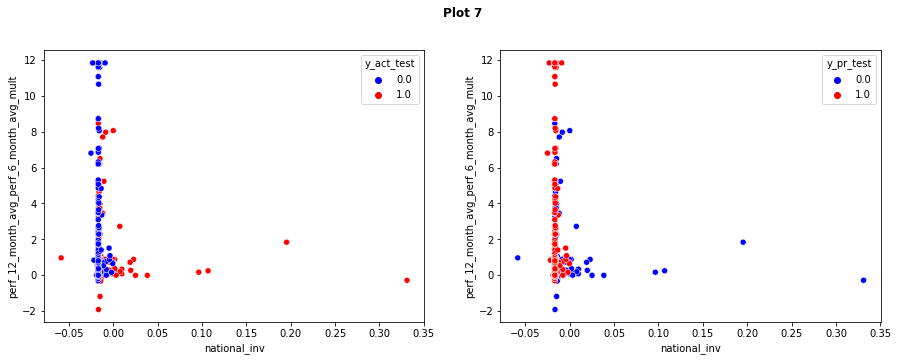

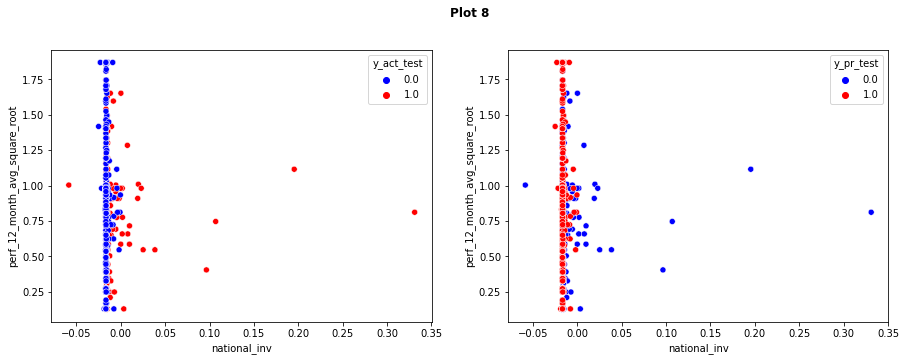

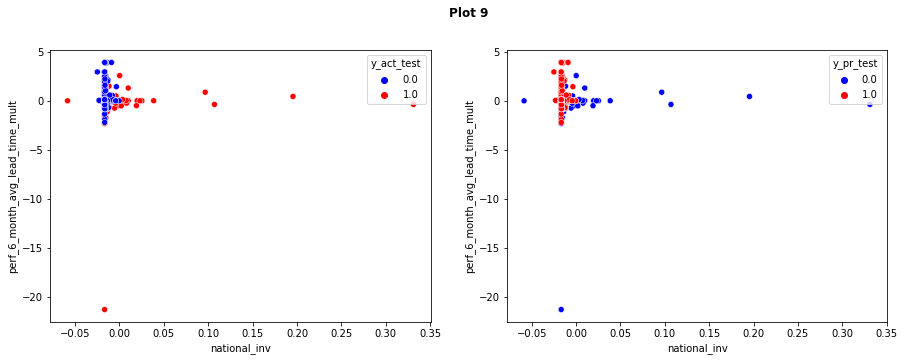

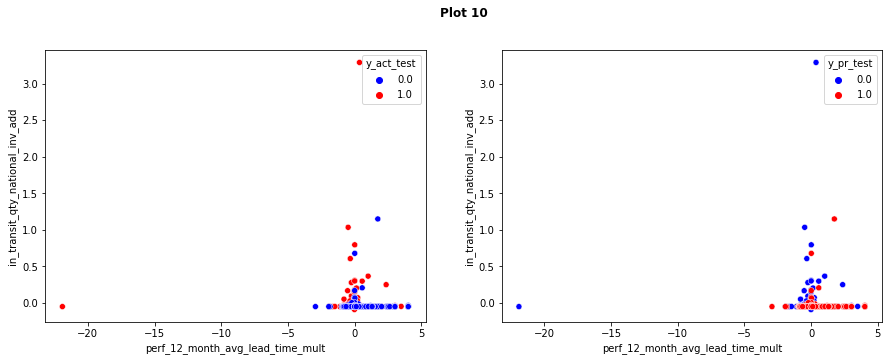

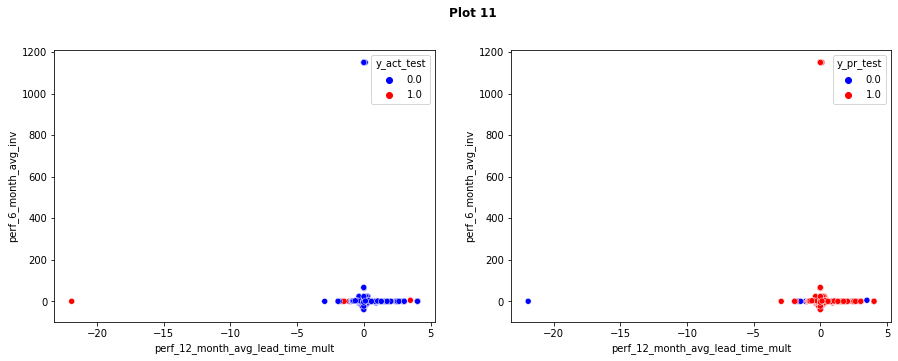

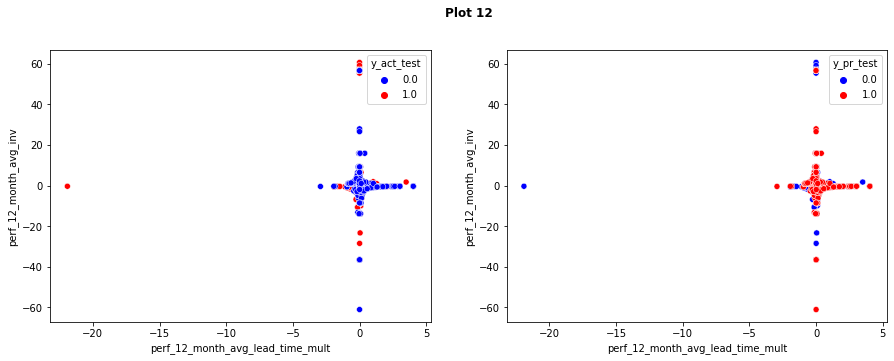

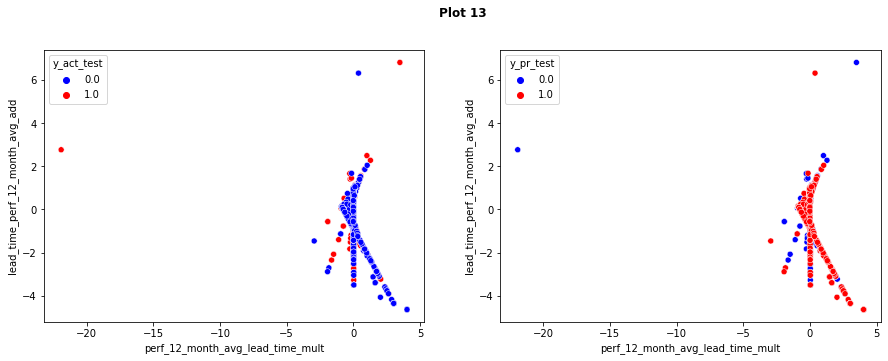

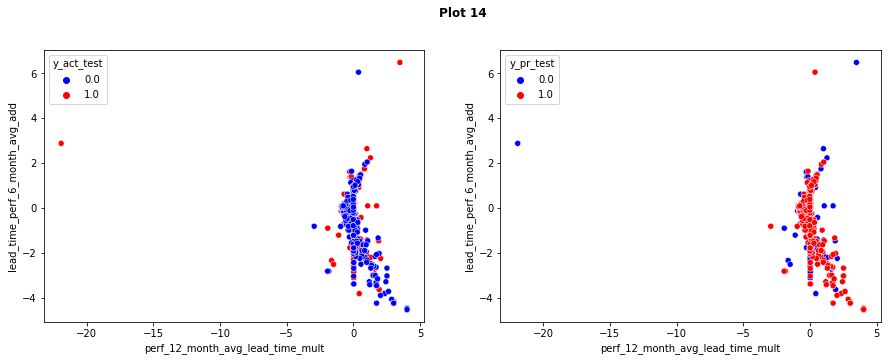

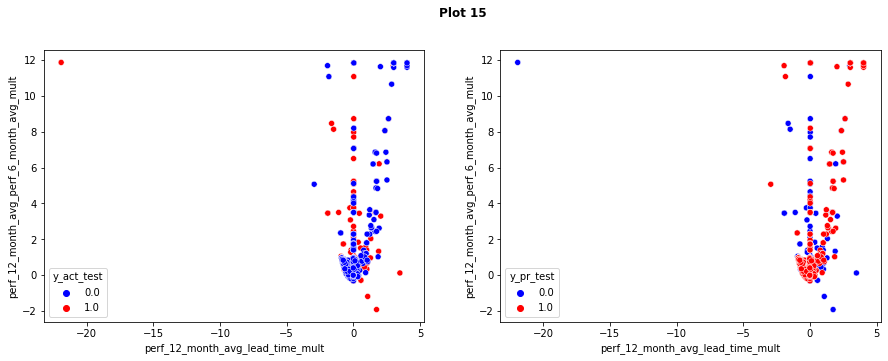

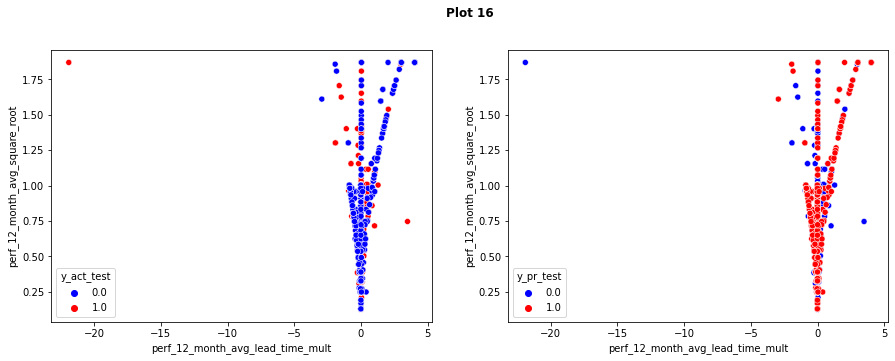

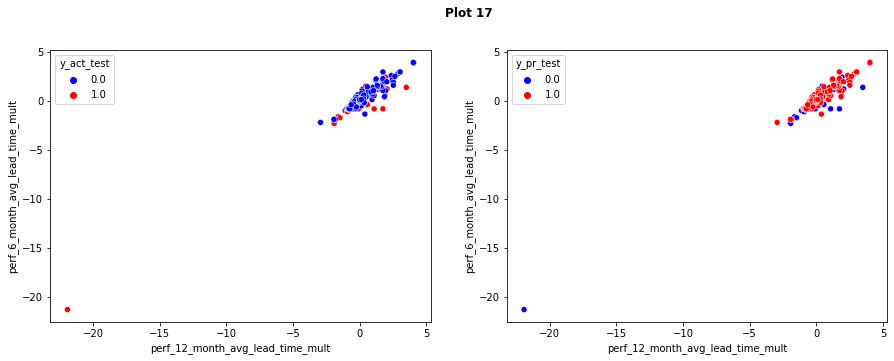

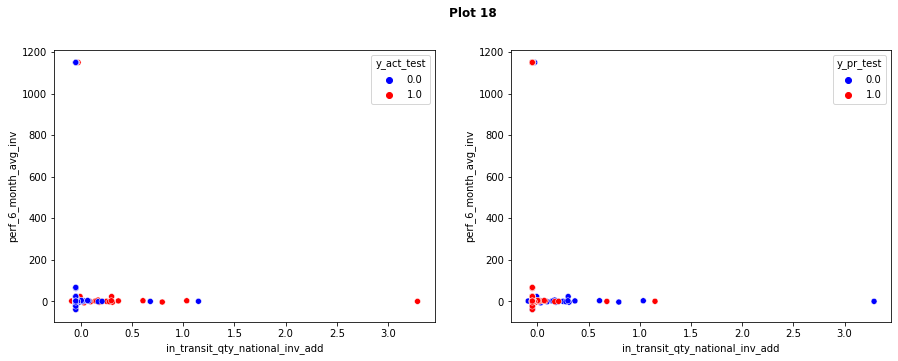

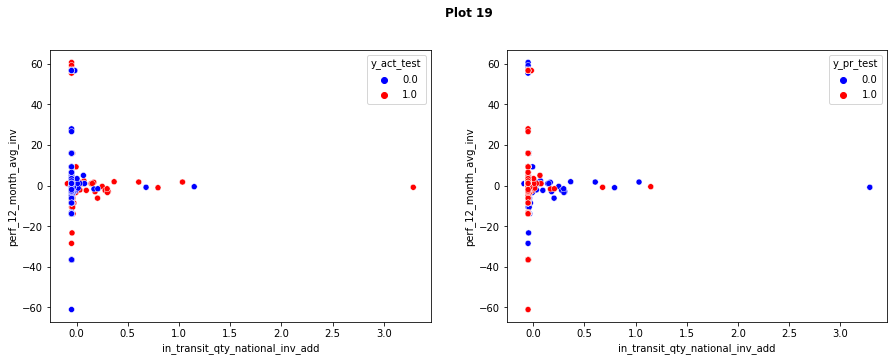

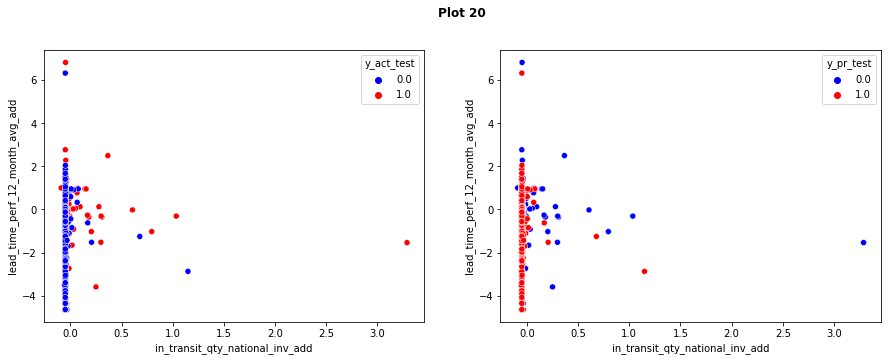

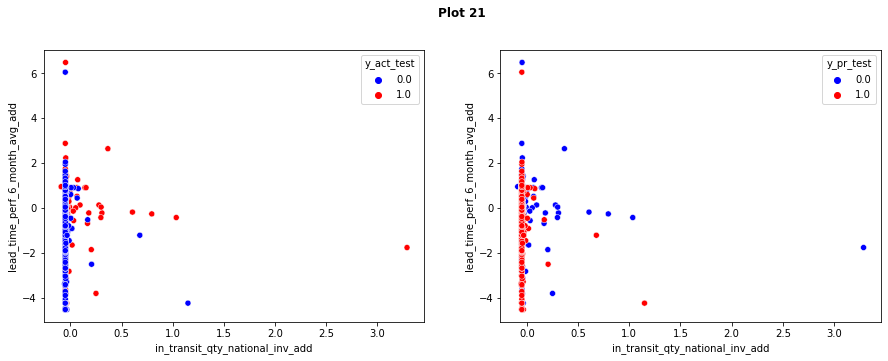

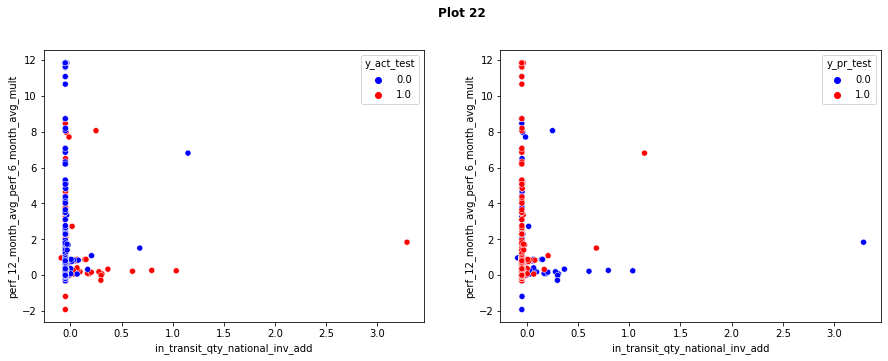

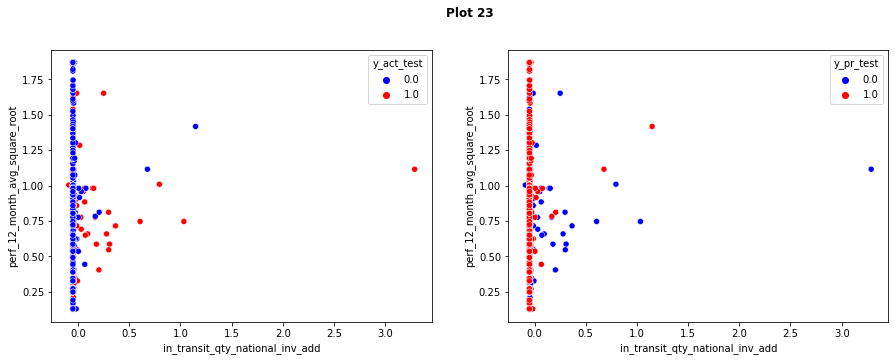

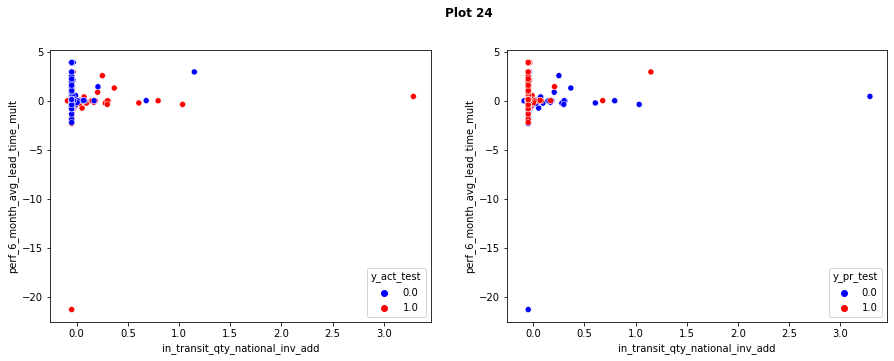

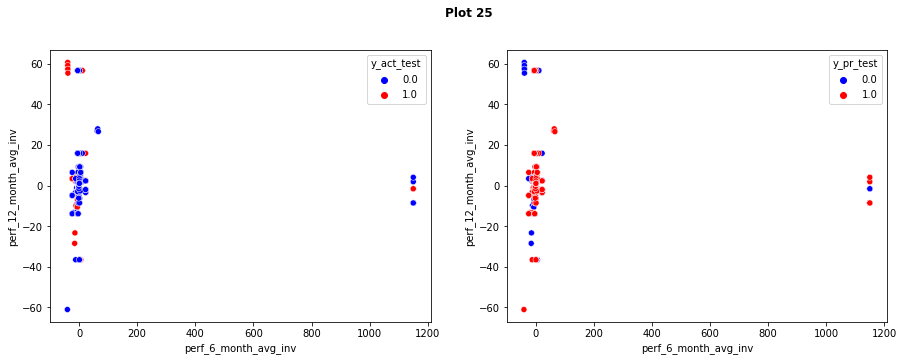

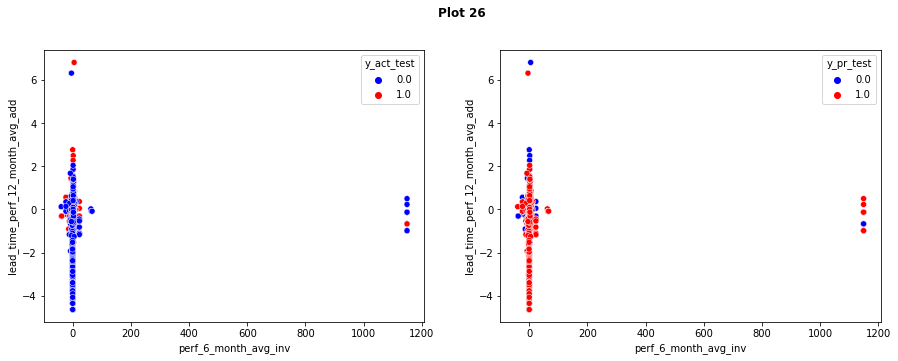

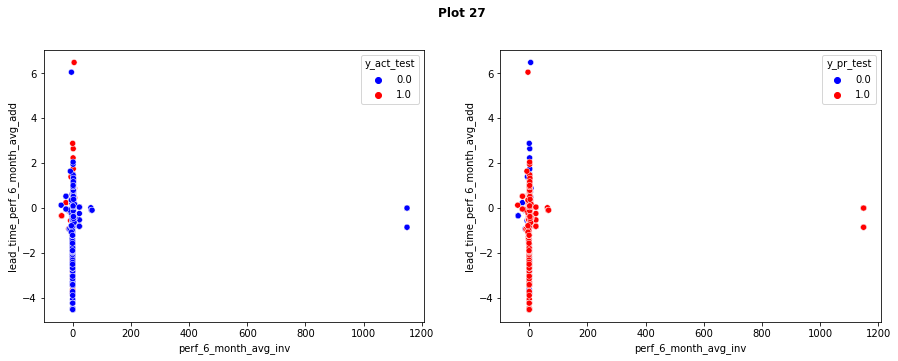

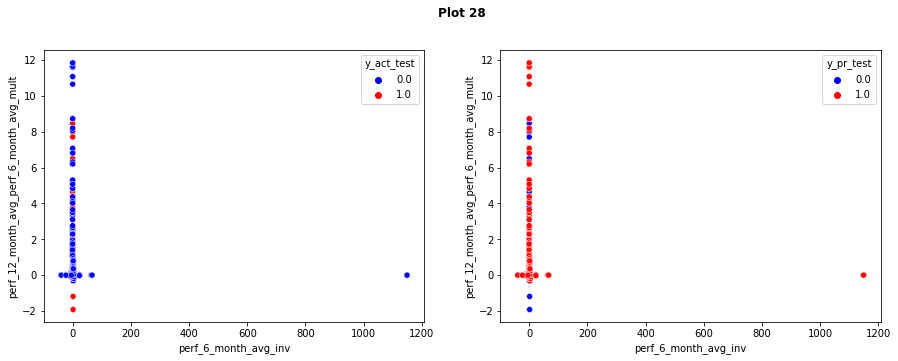

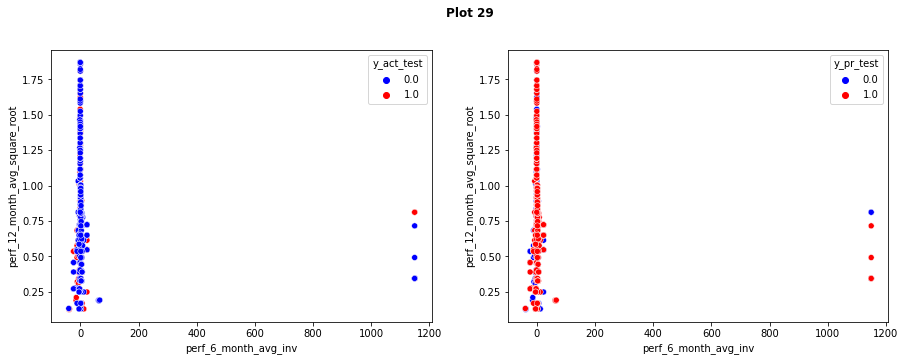

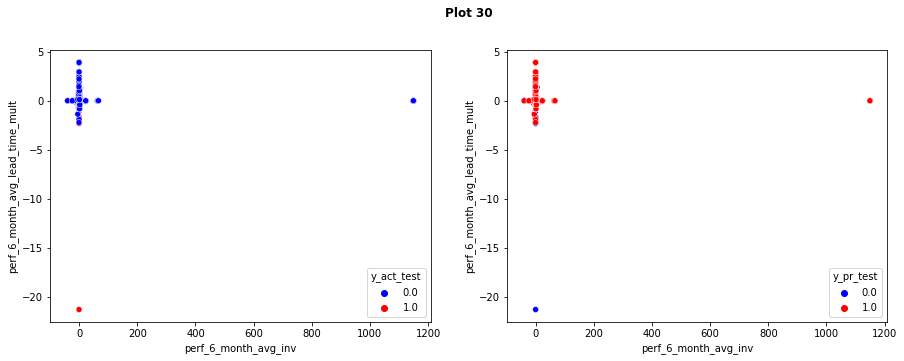

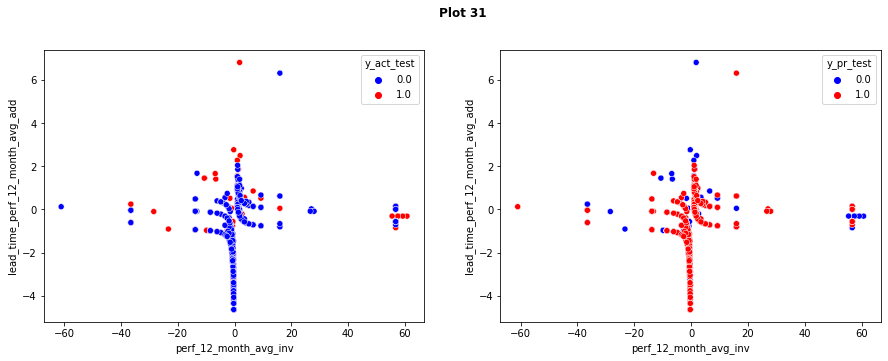

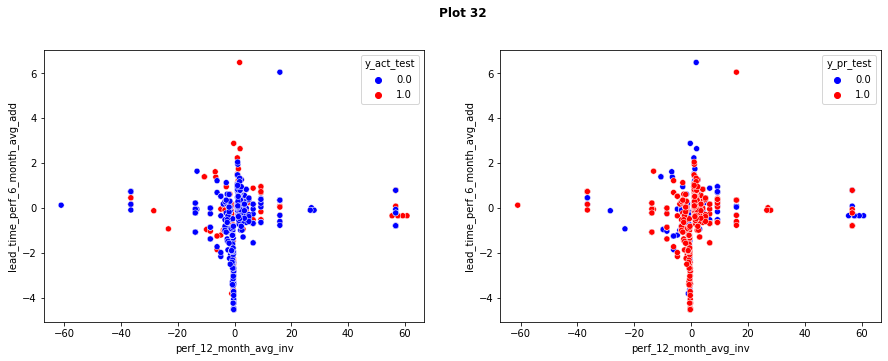

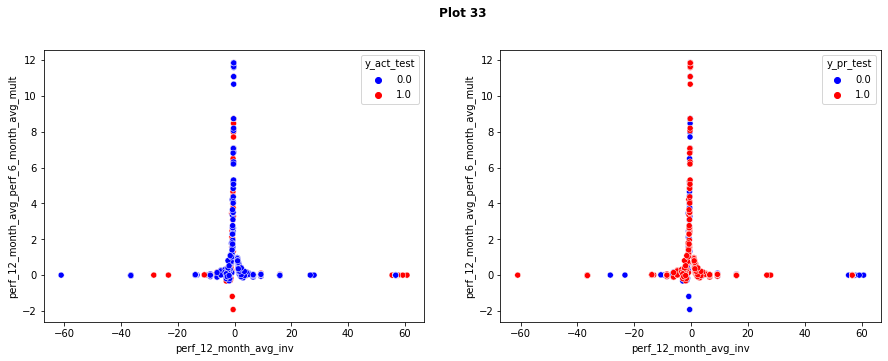

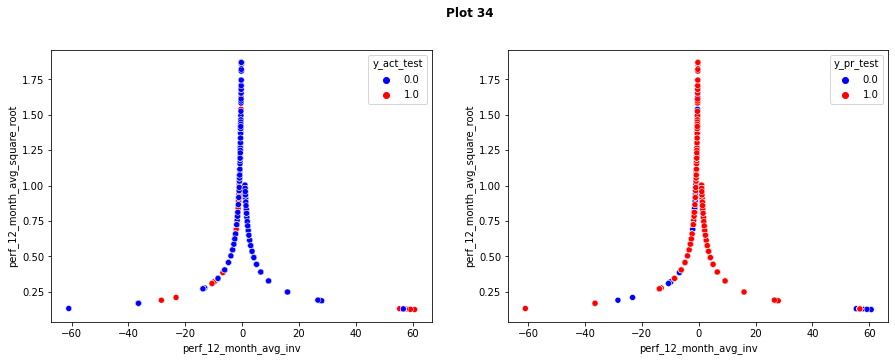

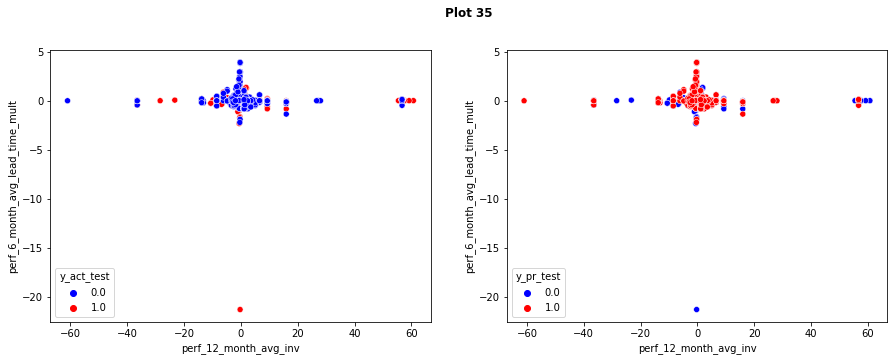

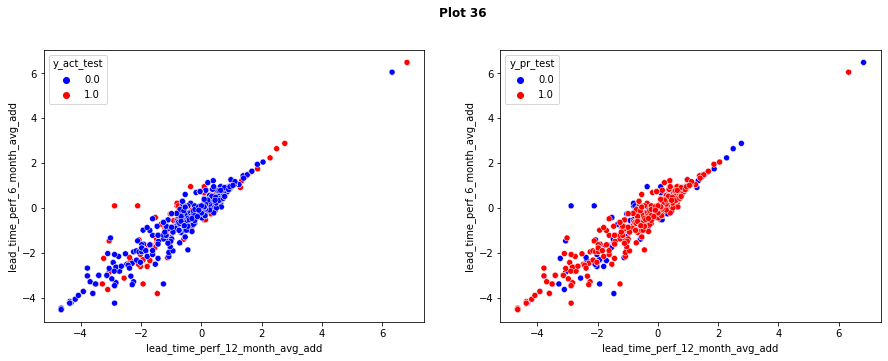

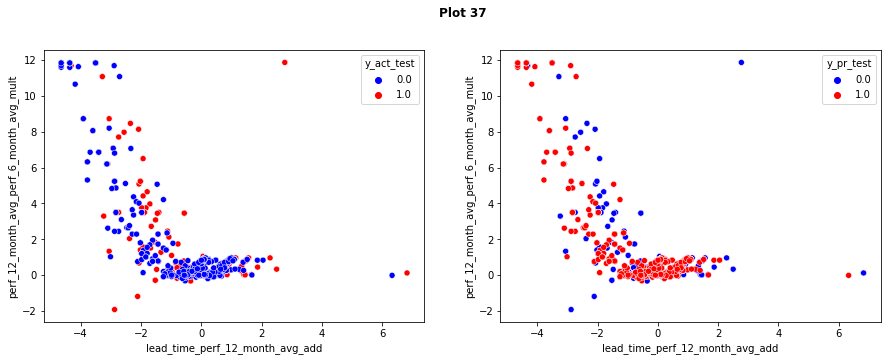

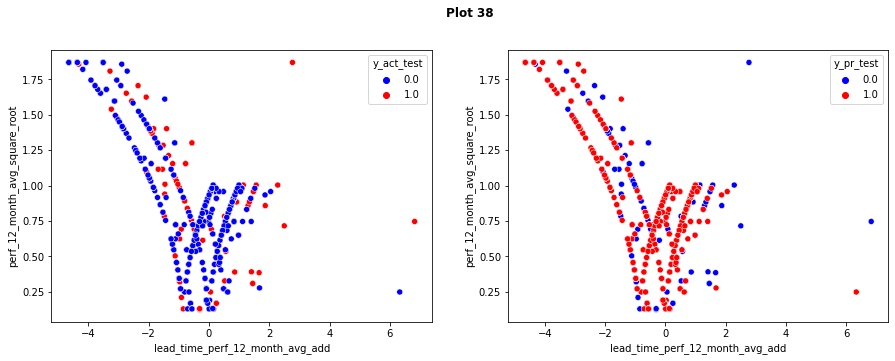

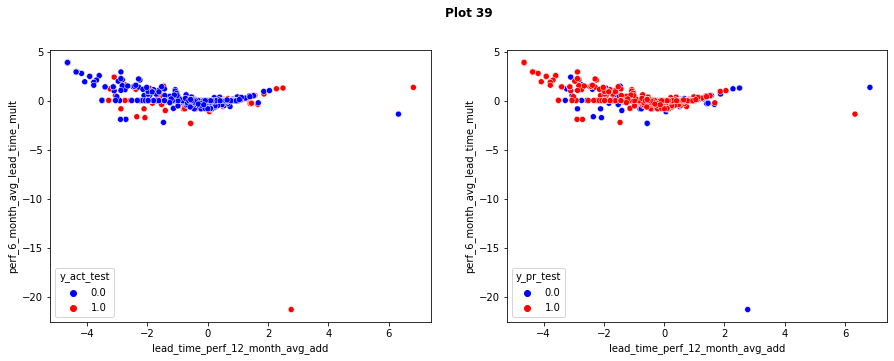

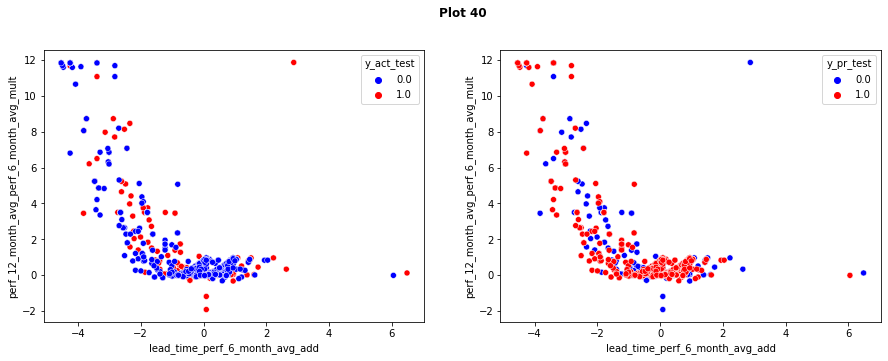

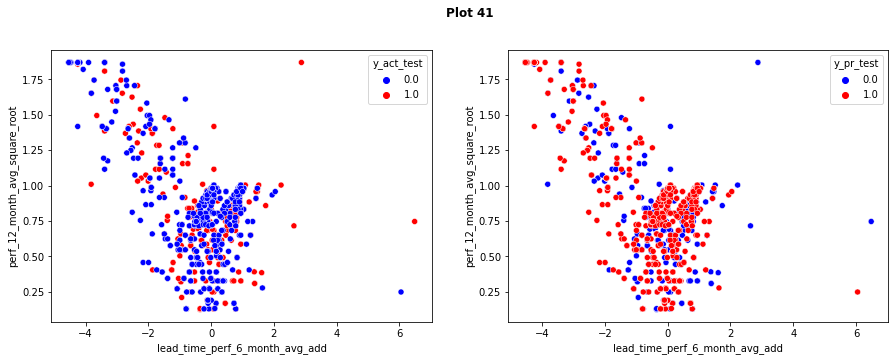

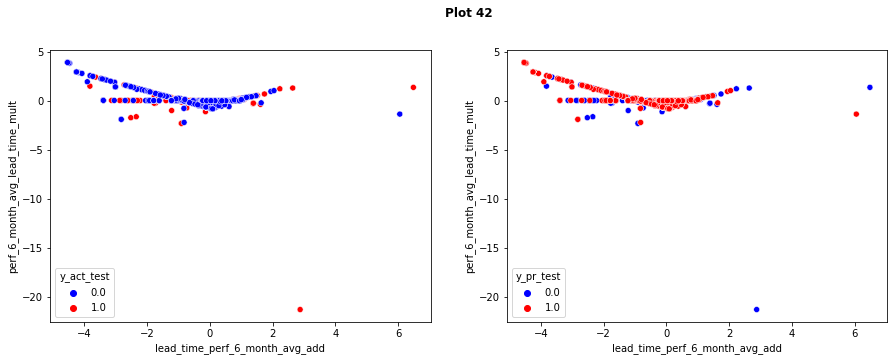

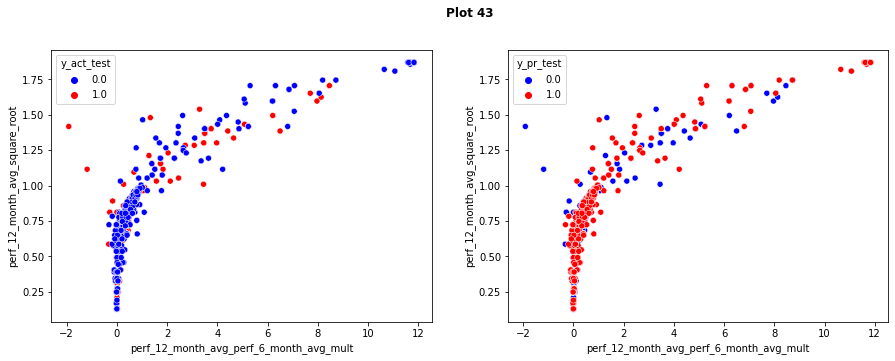

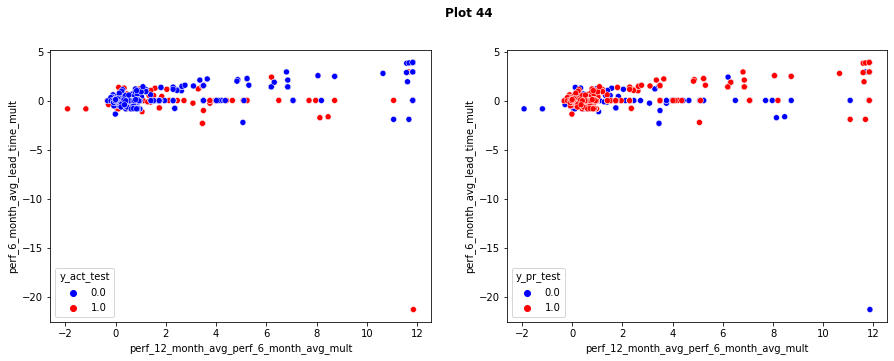

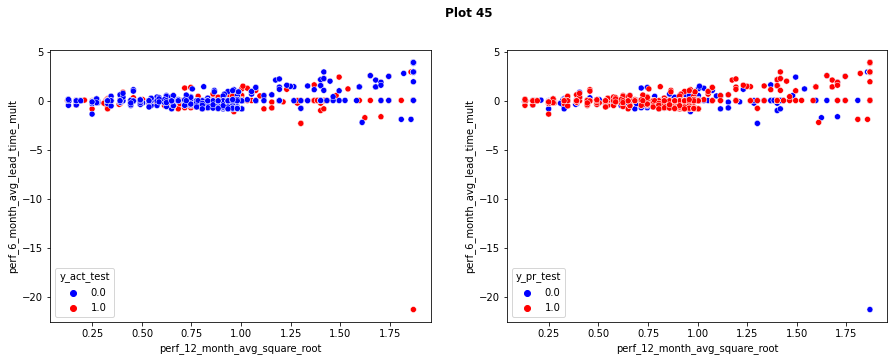

In [54]:
fig = plt.figure(figsize=(45,45))
fig.tight_layout(pad=3.0)
fig.suptitle('Checking data distribution for actual and predicted points for misclassified dataset', fontsize=20, y=1,weight='bold')
for idx, val in enumerate(itertools.combinations(imp_cols_list,2)):
  fig,ax=plt.subplots(1, 2, figsize=(15,5))
  sns.scatterplot(x=val[0], y=val[1], data=x_test_misclf_under,ax=ax[0], hue='y_act_test',palette=['blue','red'])
  sns.scatterplot(x=val[0], y=val[1], data=x_test_misclf_under, ax=ax[1],hue='y_pr_test',palette=['blue','red'])
  ax[0].set_title("Plot " + str(idx+1), x=1.1,y=1.1 ,fontweight ="bold")
  

**Observations**
* In all the above shown plots for correct and misclassifed datasets, we could see model is unable to predict correctly when there are high density of opposite labeled points clustered togthered.Since the model takes the best decision  there are some points which are getting missed out to be classified correctly

#### 5.3.3 Scatter Plot for predicted points for correctly classified and misclassified dataset

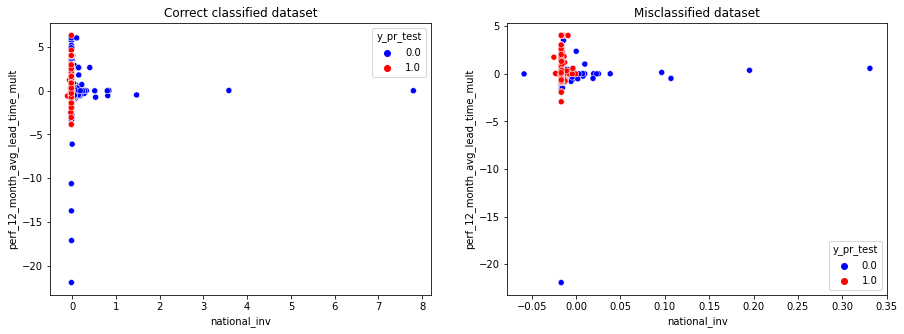

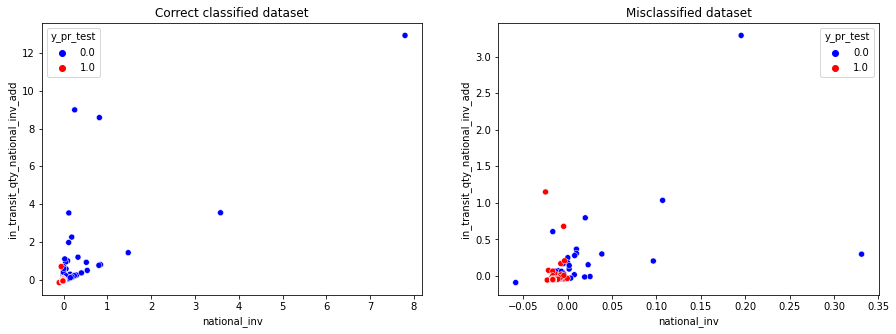

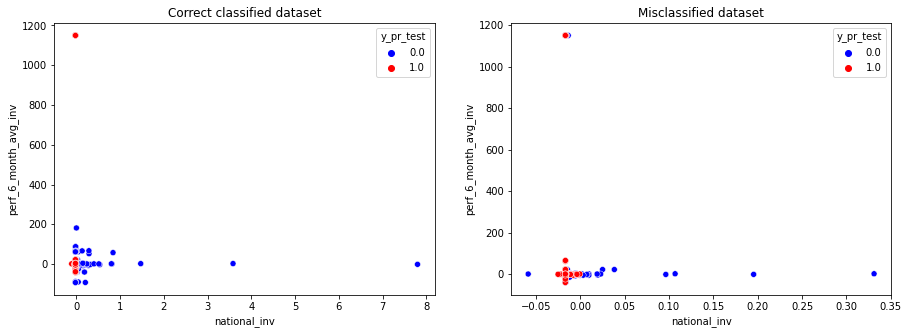

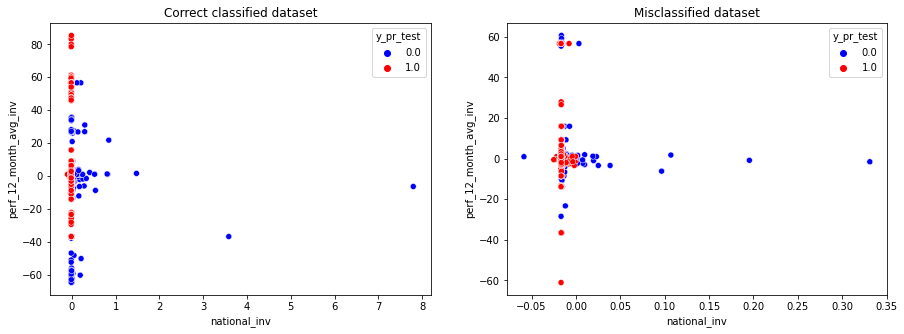

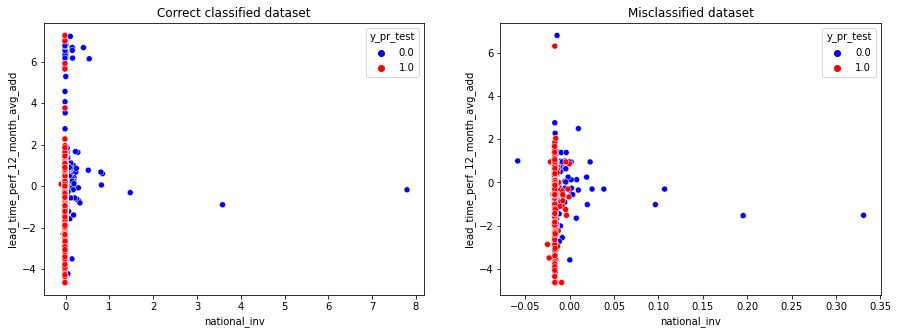

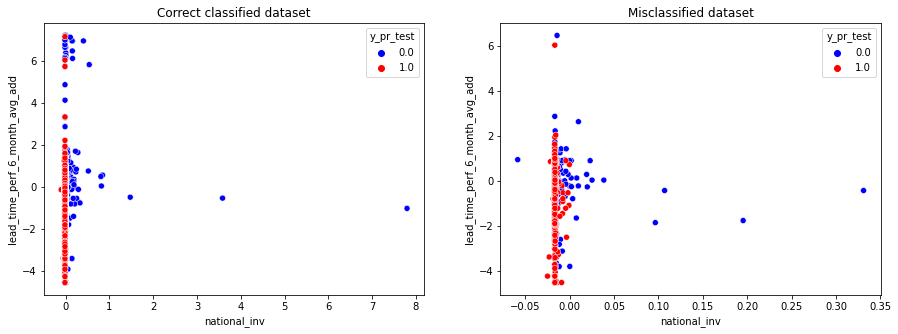

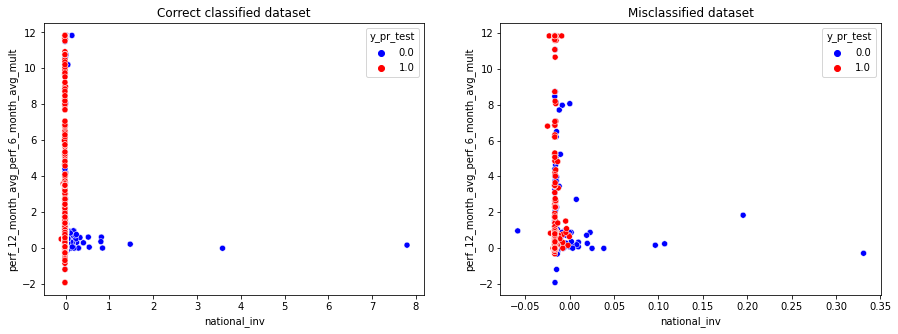

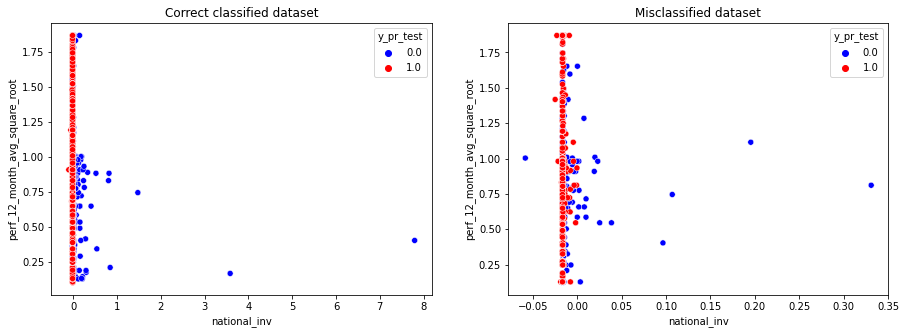

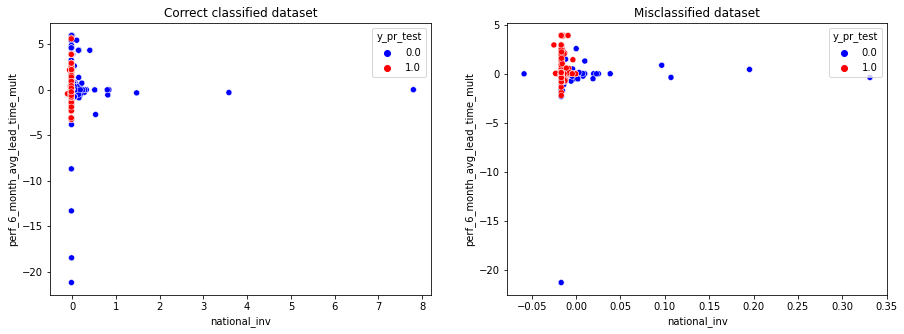

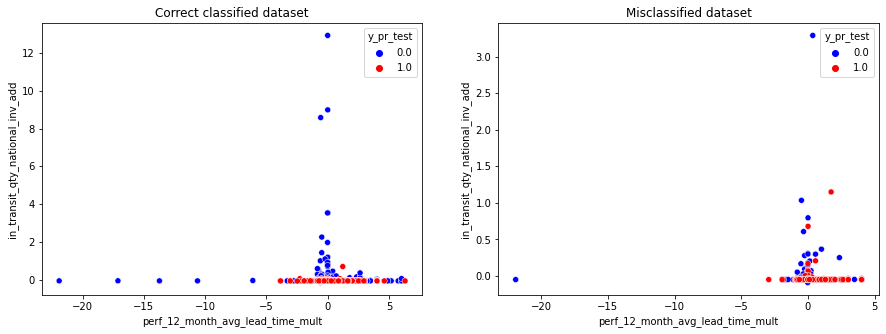

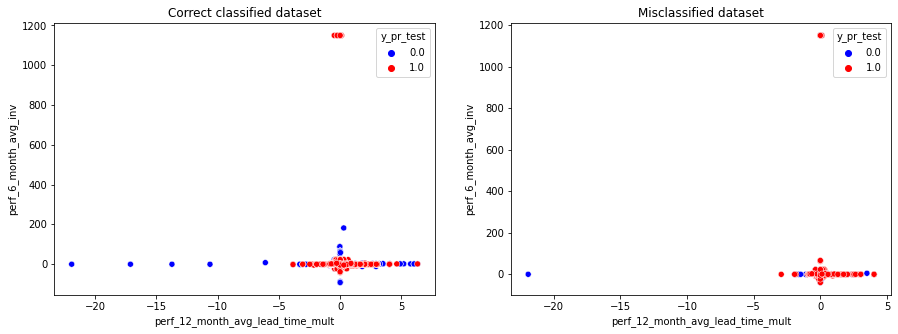

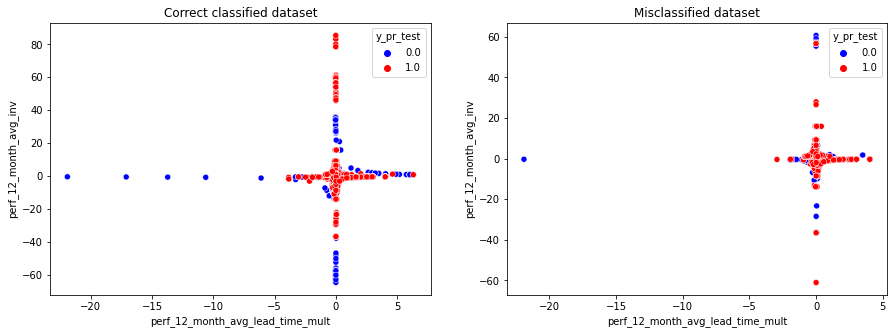

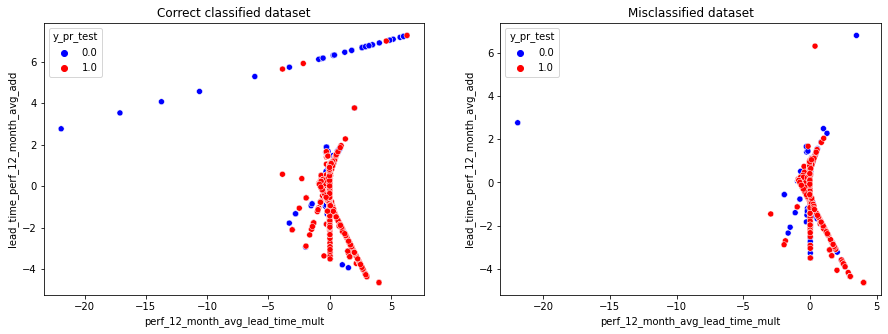

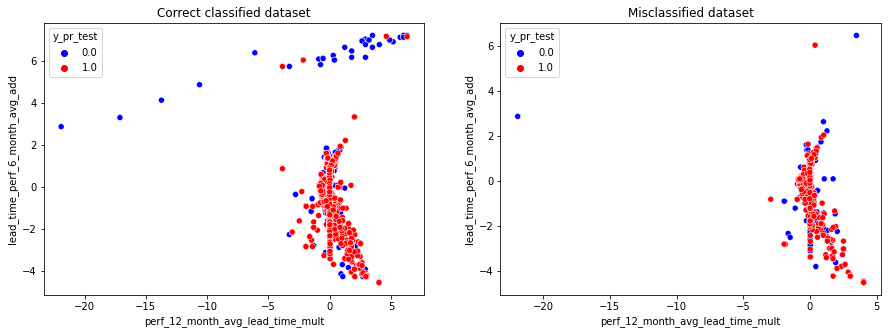

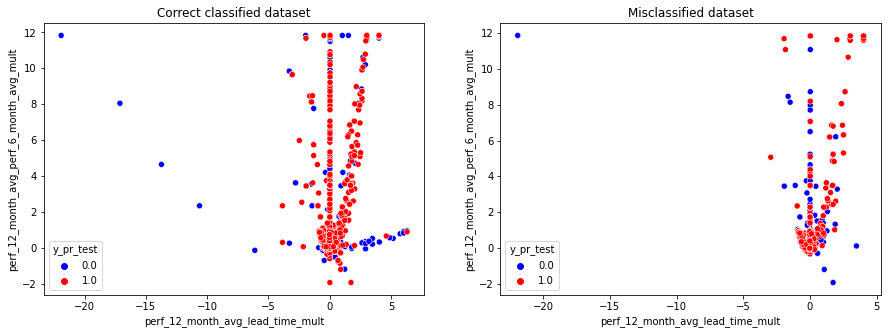

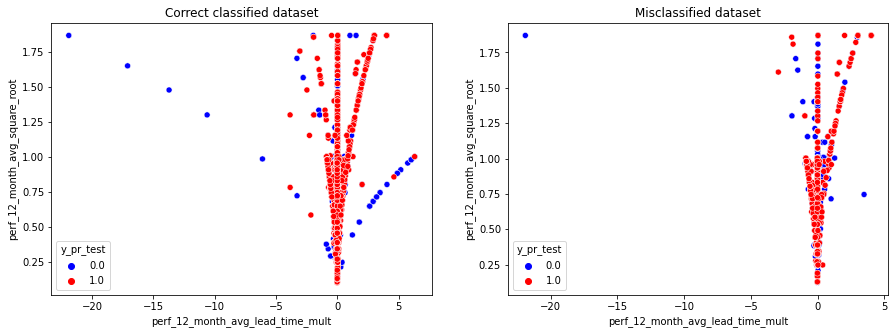

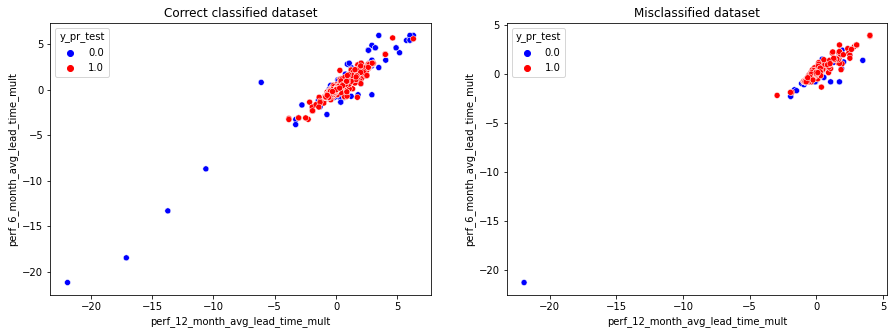

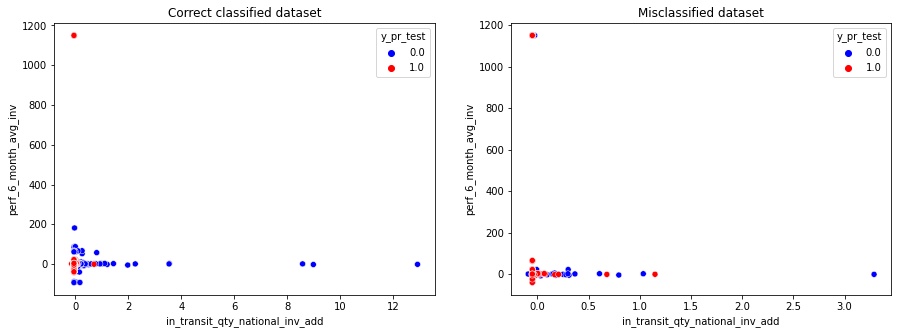

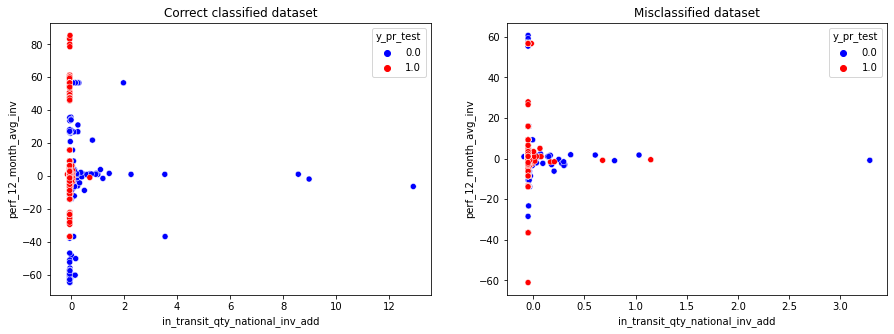

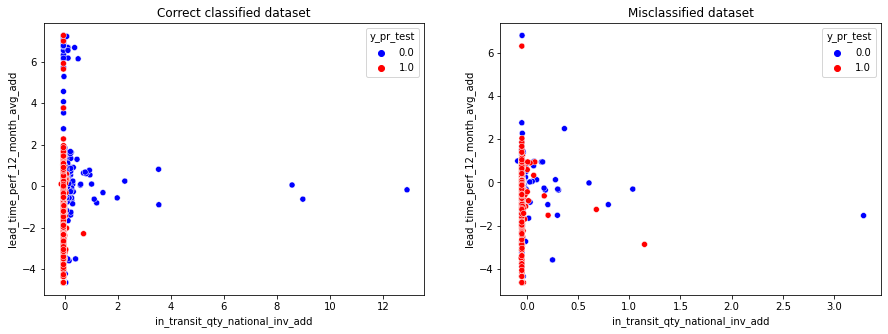

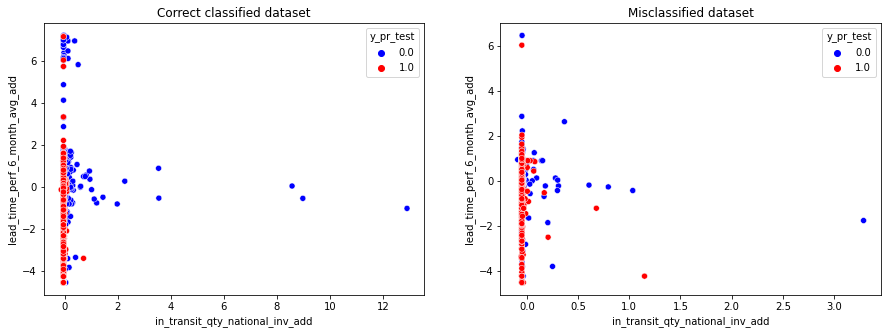

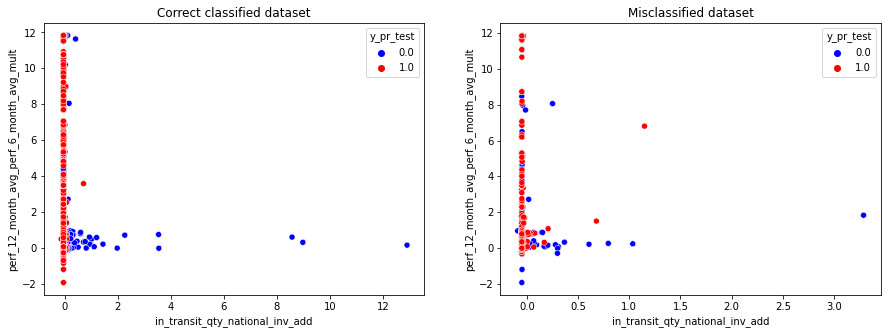

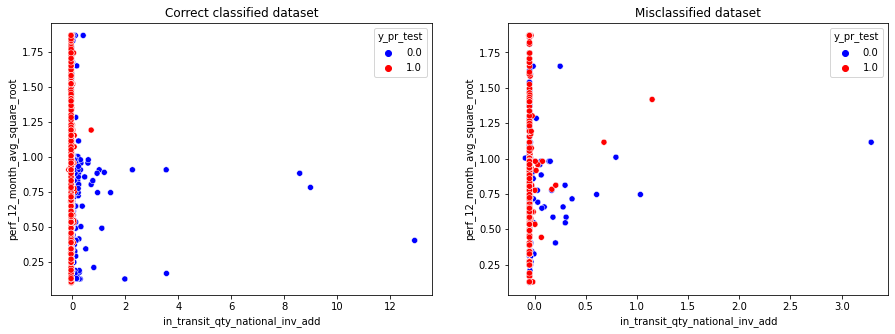

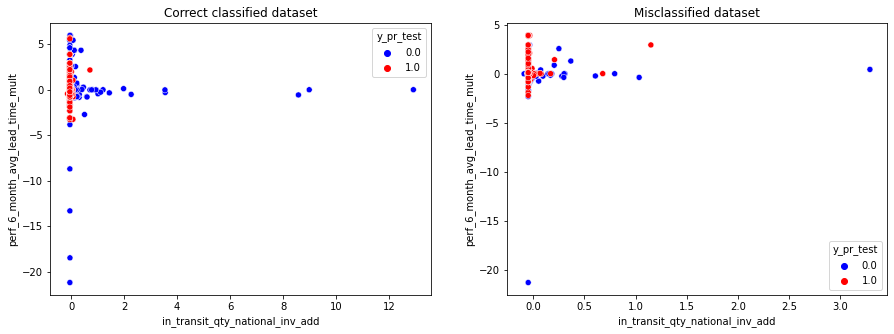

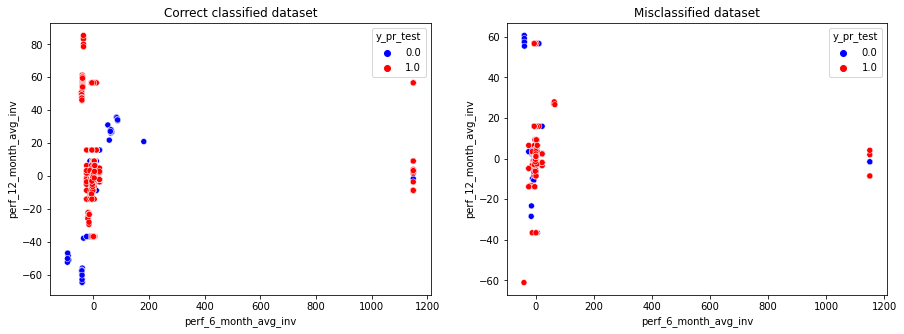

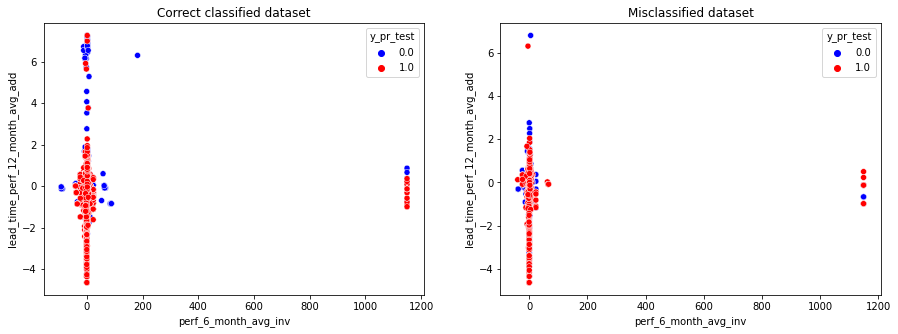

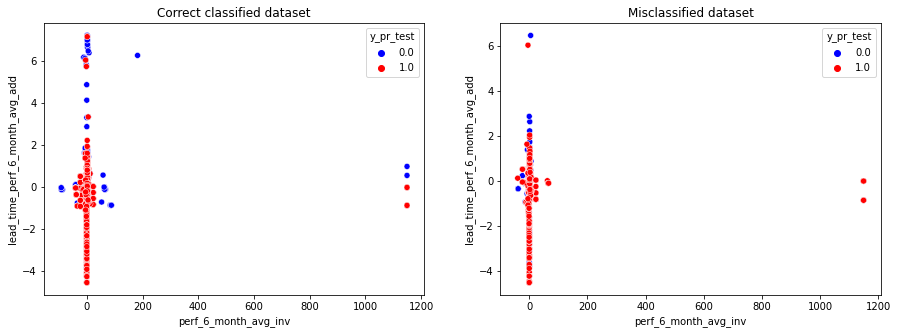

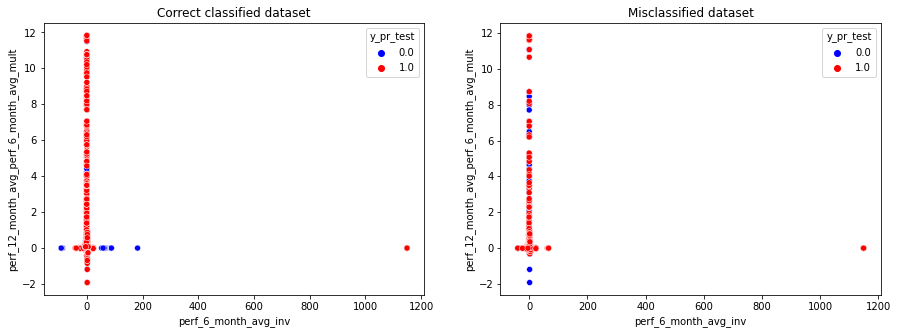

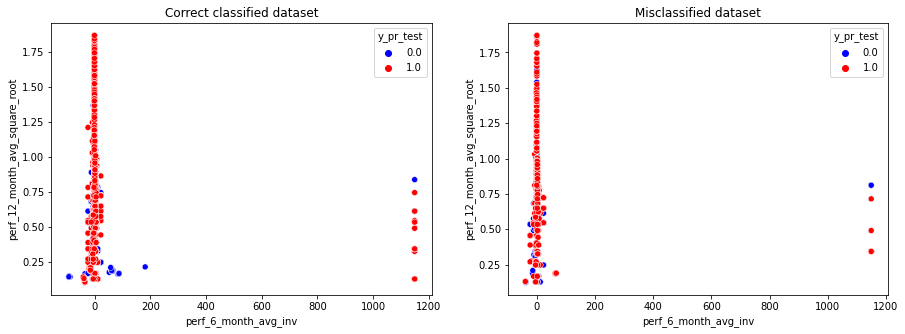

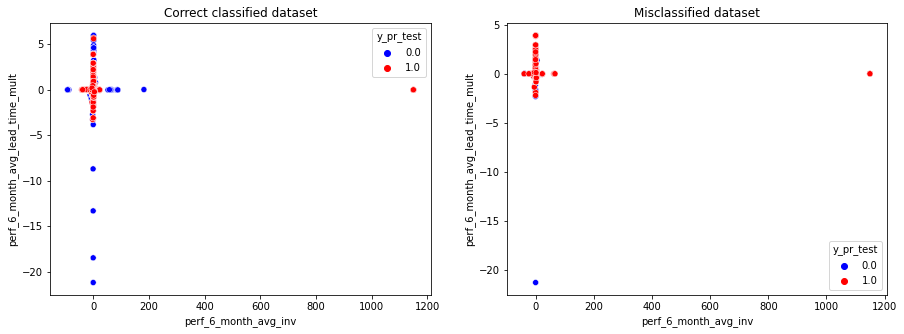

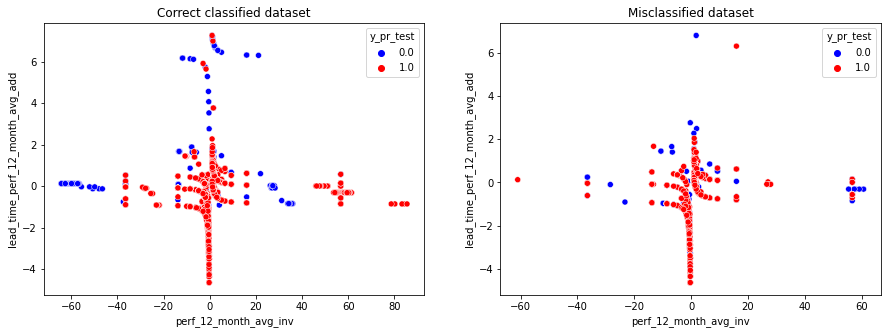

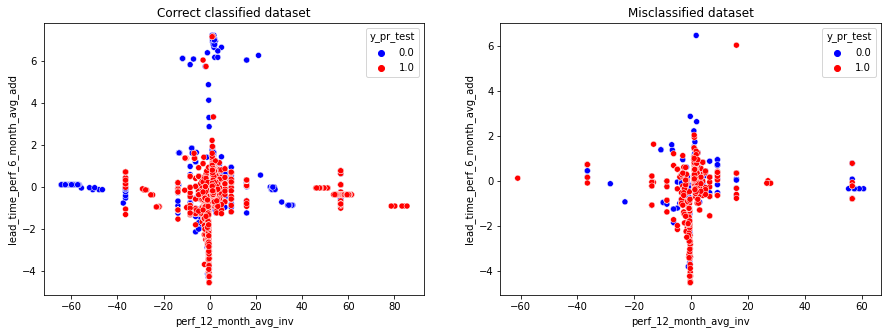

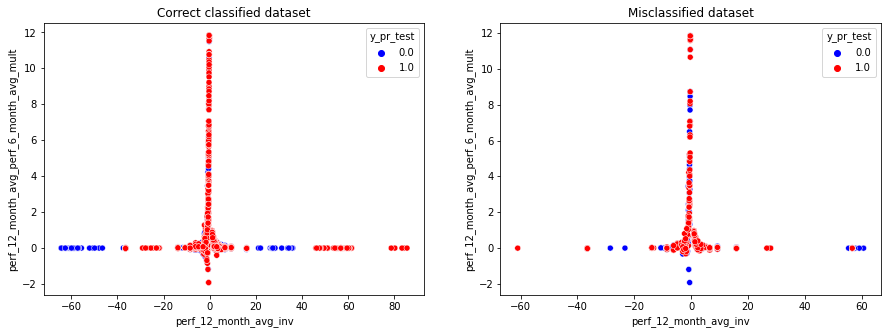

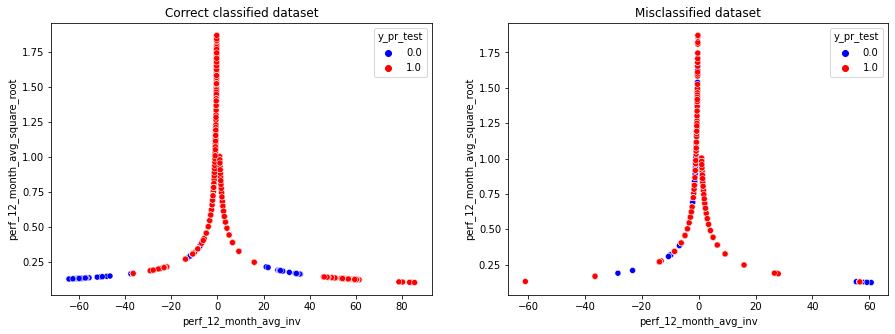

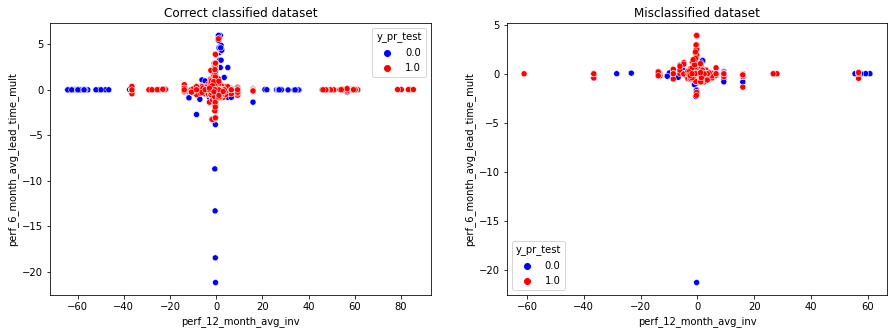

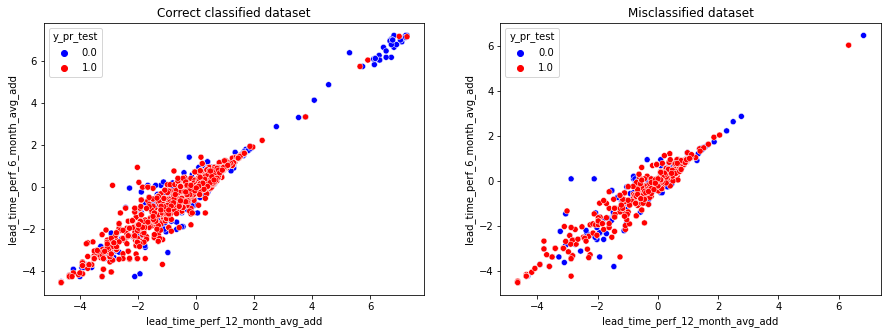

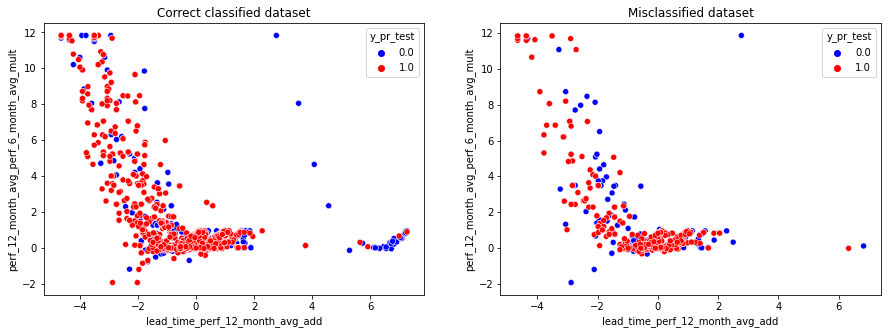

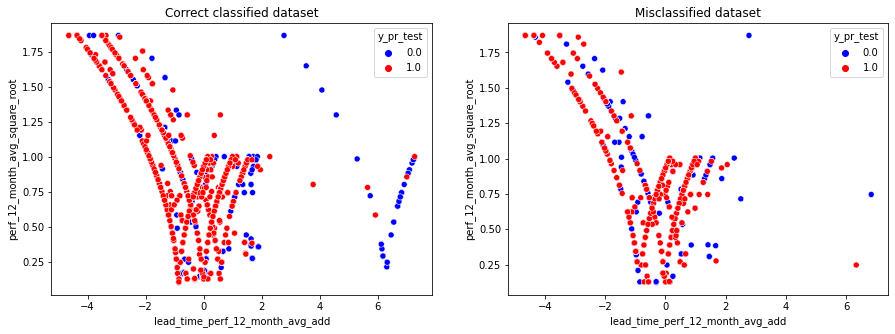

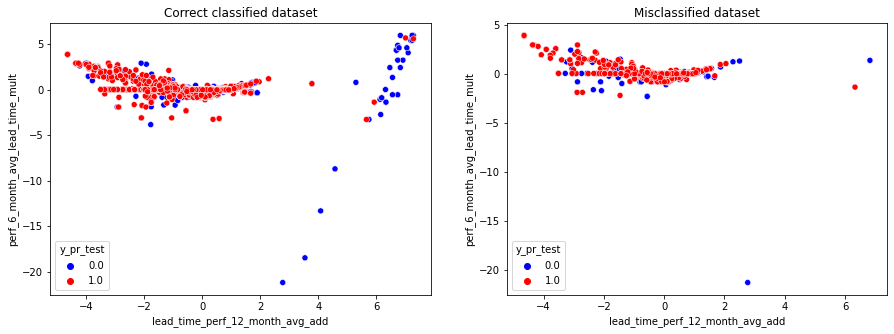

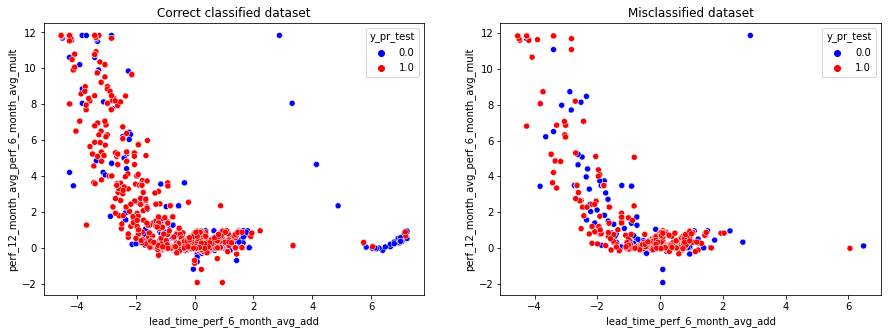

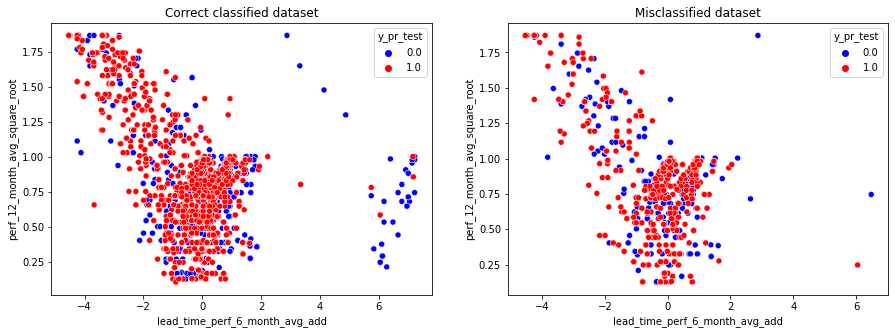

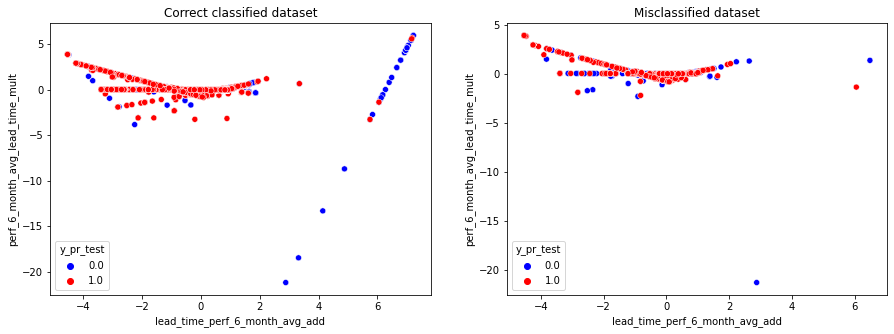

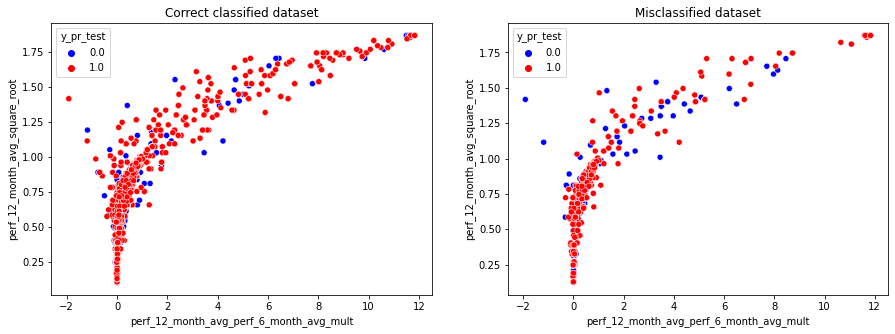

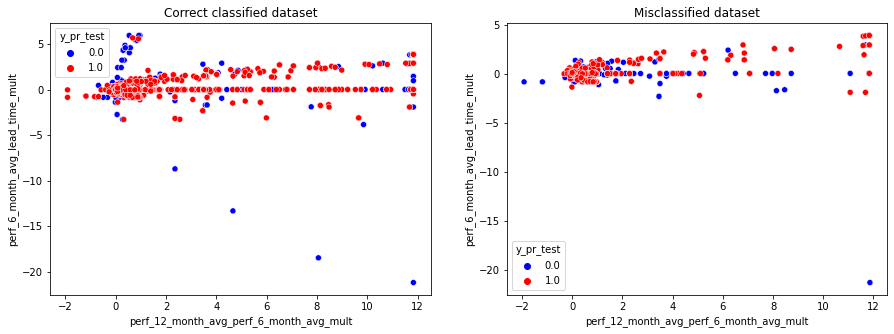

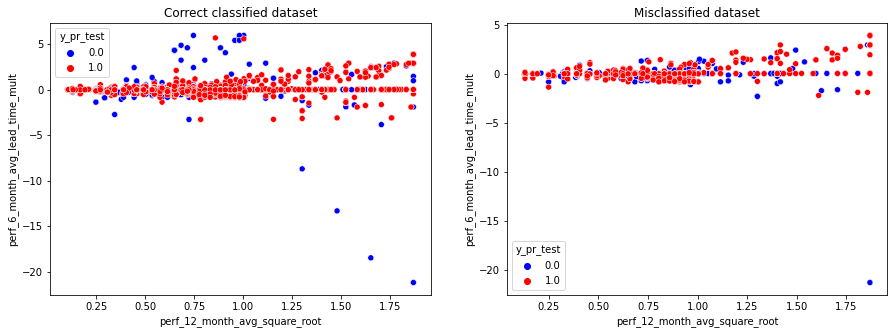

In [55]:
#feat_list=['forecast_3_month_local_bo_qty_add','local_bo_qty_forecast_6_month_add','in_transit_qty_forecast_6_month_mult','national_inv','local_bo_qty_forecast_3_month_add','forecast_3_month','national_inv_in_transit_qty_add','forecast_3_month_in_transit_qty_mult','national_inv_square_root','national_inv_log']
for idx, val in enumerate(itertools.combinations(imp_cols_list,2)):
 
 fig,ax=plt.subplots(1, 2, figsize=(15,5))
 sns.scatterplot(x=val[0], y=val[1], data=x_test_corclf_under,ax=ax[0], hue='y_pr_test',palette=['blue','red'])
 sns.scatterplot(x=val[0], y=val[1], data=x_test_misclf_under, ax=ax[1],hue='y_pr_test',palette=['blue','red']).set_title('Misclassified dataset')
 ax[0].set_title('Correct classified dataset')
 ax[1].set_title('Misclassified dataset')


**Observations**
* As can be verified from the scatter plot the correctly classified and misclassified datasets are higly overlapping which means that the misclassification is the result of highly overlapping opposite labeled points which model is unable to identify.
